# Cycling Heart Rate Project
## EECS 395 Reinforcement Learning 
### By: Eric Yang, Nicolas Tyjeski

**Background & Motivation:** In cycling, heart rate is often used as a metric to evaluate an athlete's effort and sometimes used to tailor workouts at specific heart rate zones. However, it is known that heart rate is unique to each person in many ways. Not only can their resting and max heart rate be different, but their bodies can respond to cadences differently (some can maintain high cadence while others need slower cadences) as well as have different power profiles (some can put out short high-bursts of power while maintaining a consistent heart rate, while others can maintain moderate power for long periods of time). Due to all of these unique factors, a model that predicts heart rate will have to be athlete-specific. Additionally, with a linear model, the learned weights can be used as a fitness metric. It may not be best used to compare athletes to athletes, but there is potential to track variations in fitness by training models using recent data and comparing to previously trained weights.

## Imitator

In this project, we use Eric's cycling data to create a linear imitator to predict his Heart Rate as a function of his power output and pedaling cadence.


In [427]:
import os
from xml.etree import ElementTree
import time
import copy
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import value_and_grad 
from autograd.misc.flatten import flatten_func
import some_plotters as plotter

# import autograd functionality
import autograd.numpy as np

# import path to datasets
datapath = 'datasets/'

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

# autoreload functi"on - so if anything behind the scenes is changeed those changes
# are reflected in the notebook without having to restart the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [507]:
# Reads the xml file and stores the data into the returned arrays: lat (latitude), lng (longitude), hr (heart rate), alt (altitude) for each trackpoint
def readin(fileName):
    full_file = os.path.abspath(os.path.join(fileName))
    dom = ElementTree.parse(full_file)
    loc = '{http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2}'
    
    hr = []
    pwr = []
    cad = []
    
    for trackpoints in dom.iter(loc + 'Trackpoint'):
        try:
            cur_cad = int(trackpoints.find(loc + 'Cadence').text)
        except AttributeError:
            cur_cad = -1
        try:
            rate = trackpoints.find(loc + 'HeartRateBpm')
            cur_hr = int(rate.find(loc + 'Value').text)
        except AttributeError:
            cur_hr = -1
        extensions = trackpoints.find(loc + 'Extensions')
        try:
            TPX = extensions.find('{http://www.garmin.com/xmlschemas/ActivityExtension/v2}TPX')
            cur_pwr = int(TPX.find('{http://www.garmin.com/xmlschemas/ActivityExtension/v2}Watts').text)
        except AttributeError:
            cur_pwr = -1
        # getting rid of dropout from the power meter
        if cur_pwr > 0 and cur_hr > 0 and cur_cad > 0:
            cad.append(cur_cad)
            hr.append(cur_hr)
            pwr.append(cur_pwr)
    data = np.hstack((np.reshape(cad,(len(cad),1)),np.reshape(pwr,(len(pwr),1)),np.reshape(hr,(len(hr),1))))
    # Remove erroneous power data
    # data = [time for time in data if time[2] !=0 ]
    cad_data = np.array([i[0] for i in data])
    pwr_data = np.array([i[1] for i in data])
    hr_data = np.array([i[2] for i in data])
    return (hr_data, cad_data, pwr_data)

# Creates a dataset in the format [hr, cad, pwr, next_hr]
def split_data(hr, cad, pwr):
    dataset = []
    for i in range(len(hr)-1):
        dataset.append([hr[i],cad[i],pwr[i],hr[i+1]])
    return dataset

# Reads in data from all data files in data folder
def read_all_files(data_folder):
    dataset = []
    for item in os.listdir(data_folder):
        if item.endswith(".xml"):
#             print(item)
            (hr, pwr, cad) = readin(data_folder + item)
            dataset = dataset + split_data(hr, pwr, cad)
    return dataset

### For modeling
# gradient descent
def gradient_descent(g,w_init,alpha,max_its,verbose): 
    # flatten the input function
    g_flat, unflatten, w = flatten_func(g, w_init)
    
    # compute gradient of flattened input function
    # when evaluated this returns both the evaluation of the gradient and the original function
    grad = value_and_grad(g_flat)
    cost_eval,grad_eval = grad(w)
    grad_eval.shape = np.shape(w)

    # record history
    w_hist = [unflatten(w)]
    train_hist = [cost_eval]
        
    # gradient descent loop
    for k in range(max_its): 
        # take descent step with momentum
        w = w - alpha*grad_eval
        
        # plug in updated w into func and gradient
        cost_eval,grad_eval = grad(w)
        grad_eval.shape = np.shape(w)
                
        # store updates
        w_hist.append(unflatten(w))
        train_hist.append(cost_eval)

        # print update
        if verbose == True:
            print ('step ' + str(k+1) + ' complete, train cost = ' + str(np.round(train_hist[-1],4)[0]))

    # print update and return
    if verbose == True:
        print ('finished all ' + str(max_its) + ' steps')
    return w_hist,train_hist

import matplotlib.pyplot as plt
def plot_series(cost_history,title='cost value', xlabel = 'iteration'):
    figure = plt.figure(figsize = (10,3))
    plt.plot(cost_history)
    plt.xlabel(xlabel)
    plt.ylabel(title,rotation = 90)
    plt.show()
    
# standard normalization function 
def standard_normalizer(x):
    # compute the mean and standard deviation of the input
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_stds = np.std(x,axis = 1)[:,np.newaxis]   

    # check to make sure thta x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(x_stds < 10**(-2))
    if len(ind) > 0:
        ind = [v[0] for v in ind]
        adjust = np.zeros((x_stds.shape))
        adjust[ind] = 1.0
        x_stds += adjust

    # create standard normalizer function
    normalizer = lambda data: (data - x_means)/x_stds

    # create inverse standard normalizer
    inverse_normalizer = lambda data: data*x_stds + x_means

    # return normalizer 
    return normalizer,inverse_normalizer

def plot_data(hr, pwr, cad, compare=None):
    figure = plt.figure(figsize = (10,6))
    plt.subplot(3,1,1)
    x = np.arange(0,np.shape(hr)[0])
    if compare is not None:
        plt.plot(x,compare, color='blueviolet', label = 'Correct')
        plt.plot(x,hr,c='b',linestyle='--', label = 'Prediction')
        plt.legend()
    else:
        plt.plot(x,hr, color='blueviolet')
    plt.title('Heart Rate')
    plt.subplot(3,1,2)
    plt.plot(x,cad, color='c')
    plt.title('Cadence')
    plt.subplot(3,1,3)
    plt.plot(x,pwr, color='b')
    plt.title('Power')
    
def plot_data_and_model(hr,cad,pwr,trained_model):
    # produce figure, plot data
    figure = plt.figure(figsize = (10,6))
    plt.subplot(3,1,1)
    x = np.arange(0,np.shape(hr)[0])
    plt.plot(x,hr, color='blueviolet', label = 'Original')
    # show fit from trained model
    nhr = trained_model(hr[:-1],cad[:-1],pwr[:-1])
    nhr = hr_inverse_normalizer(nhr)
    cost = np.sum((nhr[:,:]-hr[1:])**2)/nhr.size
    plt.plot(np.arange(0,np.shape(nhr)[1]),nhr[0],c='b',linestyle='--', label = 'Prediction')
    plt.title('Heart Rates')
    plt.legend()
    
    plt.subplot(3,1,2)
    plt.plot(x,cad)
    plt.title('Cadence')
    
    plt.subplot(3,1,3)
    plt.plot(x,pwr)
    plt.title('Power')
    plt.show()
    return nhr, cost
    
    
### For the different models

# Using a linear model with only the previous one timestep
def model(w,hr,cad,pwr):
    hrnext = w[0] + w[1]*hr + w[2]*cad + w[3]*pwr
    return hrnext

def least_squares(w,hr,cad,pwr):
    hr1 = model(w,hr,cad,pwr)
    cost = np.sum((hr1[:,:-1]-hr[:,1:])**2)
    return cost/hr.size

# Using a SEQUENTIAL linear model where only the first HR value is given
def seq_model(w, hr_init, cad, pwr):
    hr = [hr_init]
    for i in range(len(cad[0])-1):
        next_hr = w[0] + w[1]*hr[i] + w[2]*cad[0][i] + w[3]*pwr[0][i]
        hr.append(next_hr)
    return np.asarray([hr])

def least_squares_seq(w, hr, cad, pwr):
    hr_pred = seq_model(w,hr[0][0],cad,pwr)
    cost = np.sum((hr[1:]-hr_pred[1:])**2)
    return cost/hr.size

def predict_cost(orig, pred):
    cost = np.sum((orig-pred)**2)
    return cost/orig.size

# Pipeline using a lookback of 10 timesteps

# Takes in the data as separate channels and formats it in a dataset with each next heart rate 
# having a set # of steps worth of previous timesteps of data
def seq_dataset(hr, cad, pwr, steps):
    dataset = []
    hr_out = []
    cad_out = []
    pwr_out = []
    hr_next = []
    for i in range(steps, len(hr)-1):
        c_hr = []
        c_cad = []
        c_pwr = []
        for ii in range(0, steps):
            c_hr.append(hr[i-(steps-ii)])
            c_cad.append(cad[i-(steps-ii)])
            c_pwr.append(pwr[i-(steps-ii)])
        hr_out.append(c_hr)
        cad_out.append(c_cad)
        pwr_out.append(c_pwr)
        hr_next.append(hr[i])
    dataset = [hr_out, cad_out, pwr_out, hr_next]
    return dataset

# Reads in data from all data files in data folder and formats it with many previous timesteps
def read_all_files_back(data_folder, steps):
    dataset = [[],[],[],[]]
    for item in os.listdir(data_folder):
        if item.endswith(".xml"):
            (hr, pwr, cad) = readin(data_folder + item)
            fileset = seq_dataset(hr, pwr, cad, steps)
            dataset[0] = dataset[0] + fileset[0]
            dataset[1] = dataset[1] + fileset[1]
            dataset[2] = dataset[2] + fileset[2]
            dataset[3] = dataset[3] + fileset[3]
    return dataset

# Using a linear model with ten previous timesteps
def back_model(w,hr,cad,pwr,steps):
    hrnext = w[0] + np.dot(np.transpose(w[1:steps+1]),np.transpose(hr)) + np.dot(np.transpose(w[steps+1:1+(steps*2)]), np.transpose(cad)) + np.dot(np.transpose(w[(steps*2)+1:(steps*3)+1]), np.transpose(pwr))
#     hrnext = w[0] + w[1]*hr[0] + w[2]*hr[1] + w[3]*hr[2] + w[4]*hr[3] + w[5]*hr[4] + w[6]*hr[5] + w[7]*hr[6] + w[8]*hr[7] + w[9]*hr[8] + w[10]*hr[9] + 
#     w[11]*cad[0] + w[12]*cad[1] + w[13]*cad[2] + w[14]*cad[3] + w[15]*cad[4] + w[16]*cad[5] + w[17]*cad[6] + w[18]*cad[7] + w[19]*cad[8] + w[20]*cad[9] +  
#     w[21]*pwr[0] + w[22]*pwr[1] + w[23]*pwr[2] + w[24]*pwr[3] + w[25]*pwr[4] + w[26]*pwr[5] + w[27]*pwr[6] + w[28]*pwr[7] + w[29]*pwr[8] + w[30]*pwr[9]
    return hrnext

def back_least_squares(w,hr,cad,pwr,hr_next,steps):
    hr1 = back_model(w,hr,cad,pwr,steps)
    cost = np.sum((hr1[0]-hr_next[0])**2)
    return cost/hr.size

## Data

Here is an example of the data for an hour-long workout. Each timestep is in seconds, Heart Rate is measured in beats per minute (bpm), Cadence is measured in revolutions per minute (rpm), and power is measured in Watts (measured from a strain guage in the pedal crank).

<IPython.core.display.Javascript object>


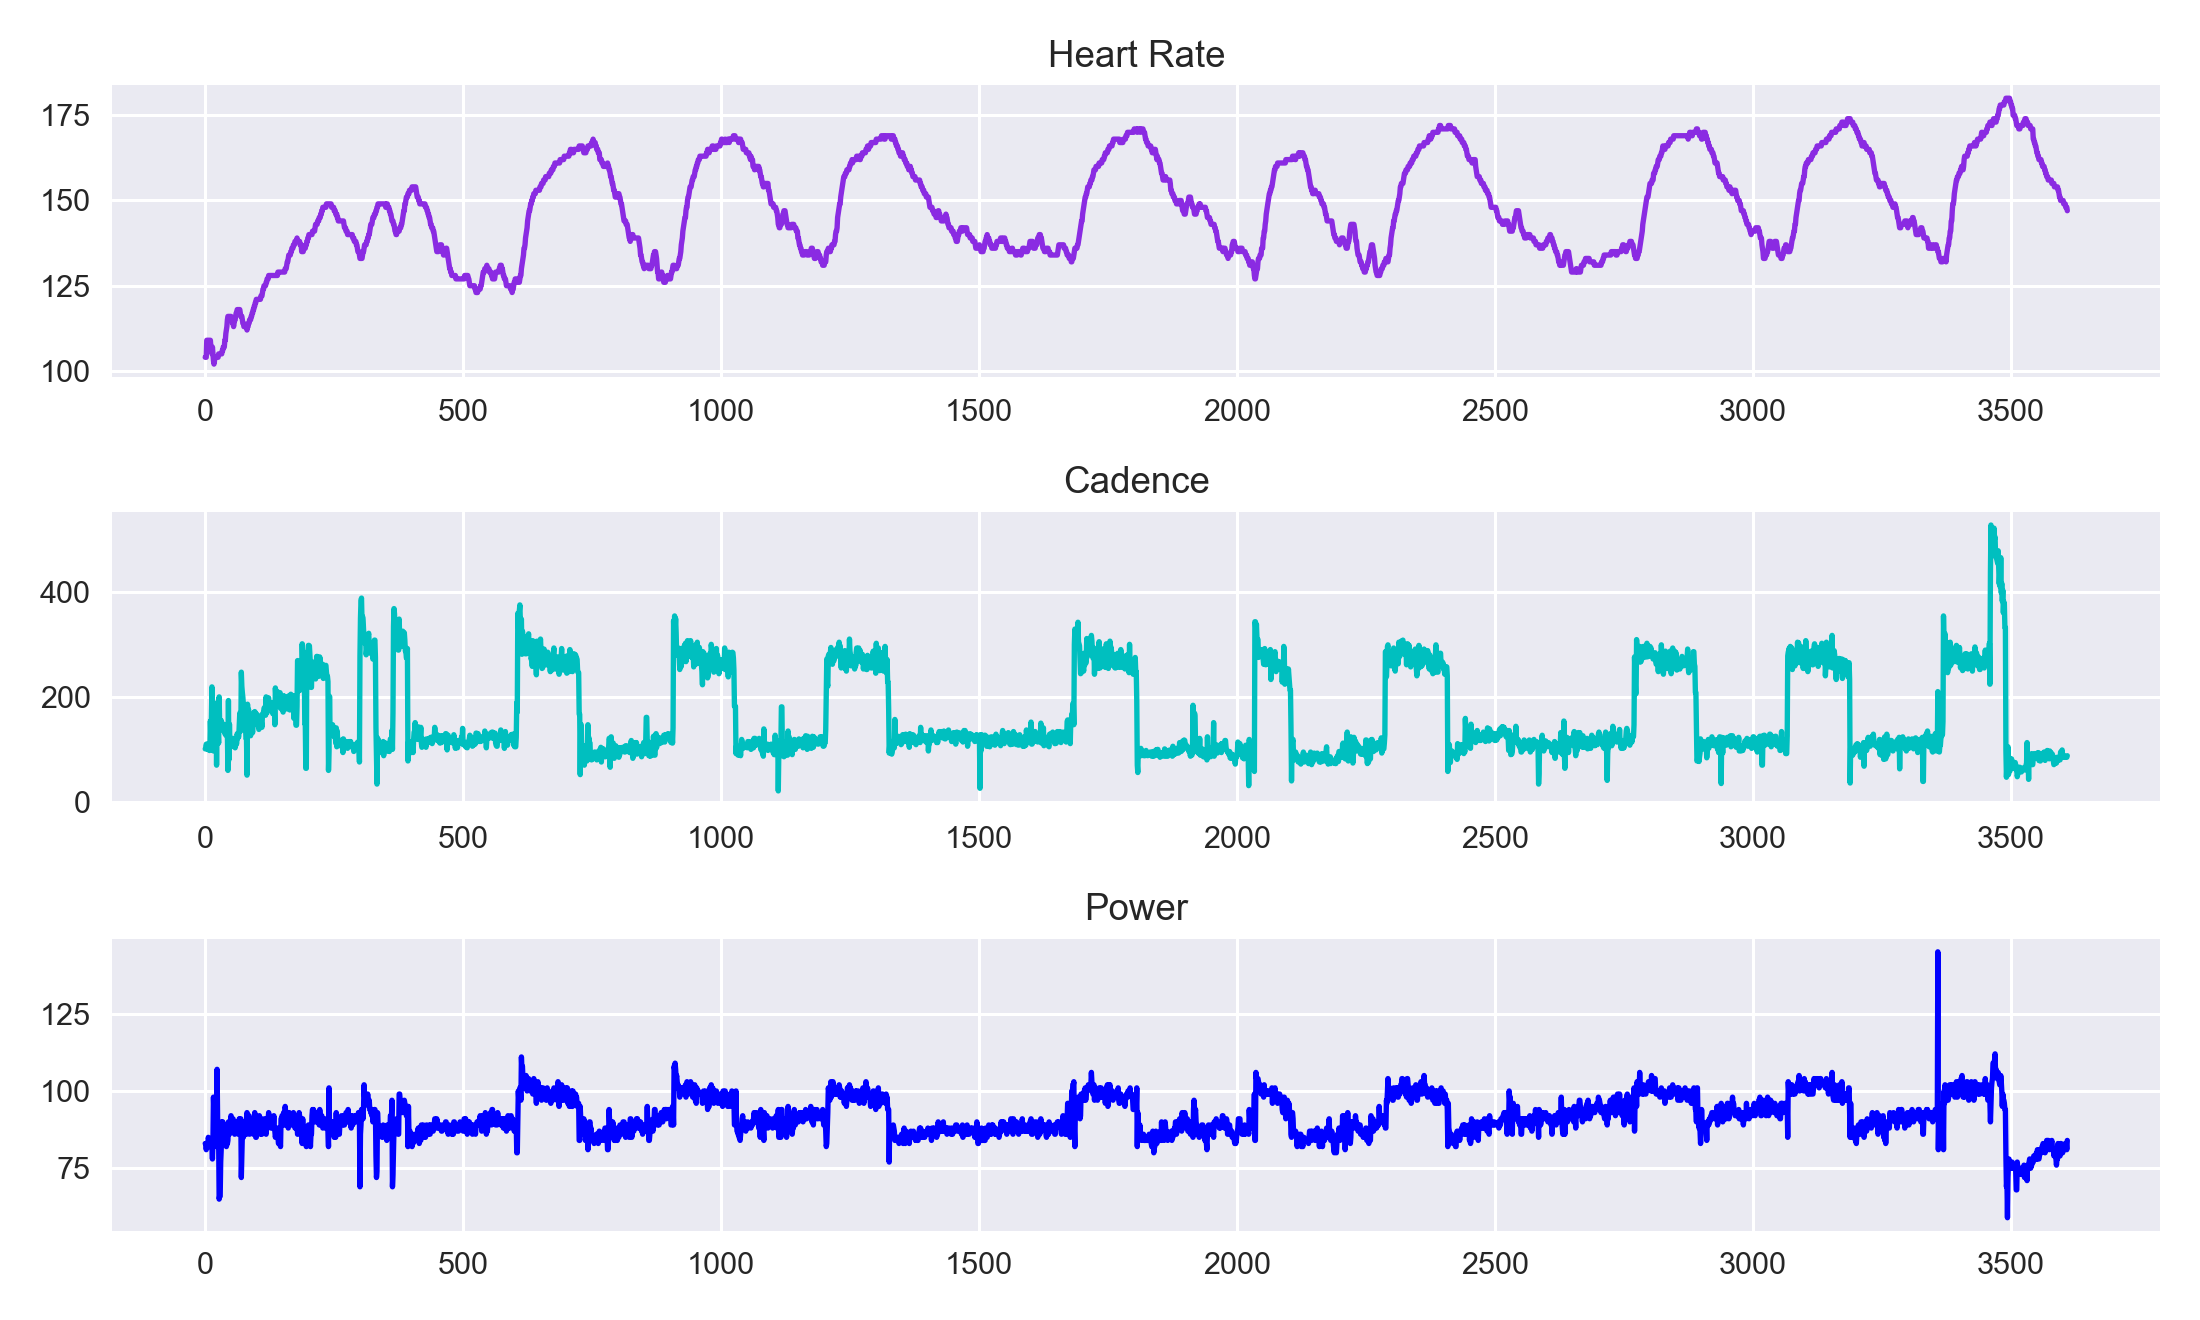

In [166]:
(hr, cad, pwr) = readin('Mills.xml')
plot_data(hr, cad, pwr)

<IPython.core.display.Javascript object>


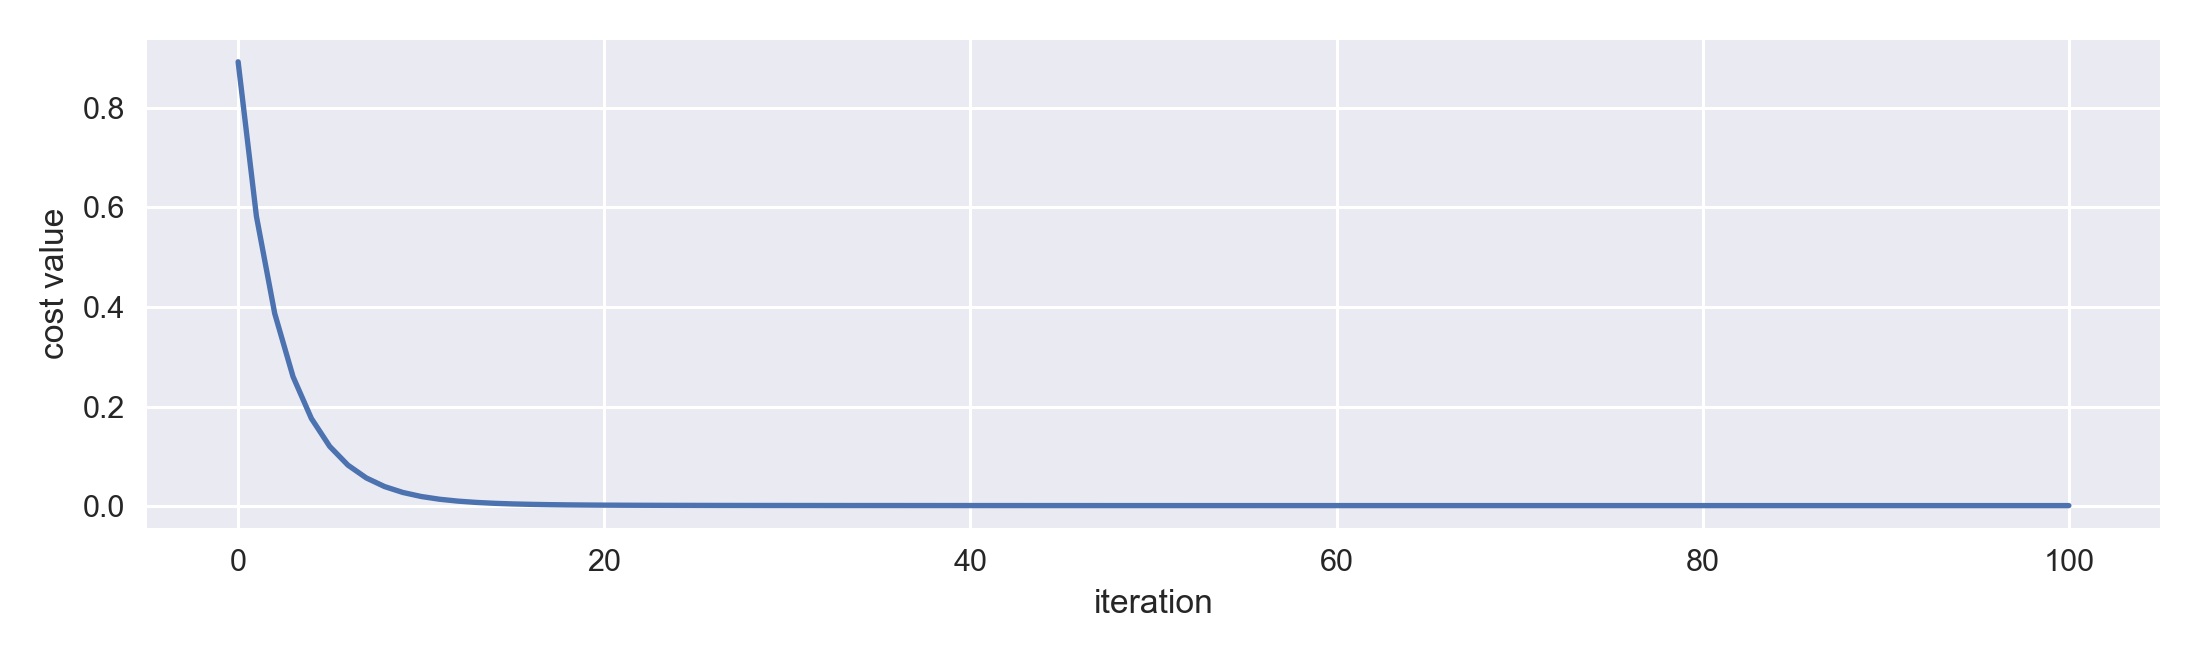

In [115]:
# Normalize the data
hr_normalizer, hr_inverse_normalizer = standard_normalizer(hr[np.newaxis])
cad_normalizer, cad_inverse_normalizer = standard_normalizer(cad[np.newaxis])
pwr_normalizer, pwr_inverse_normalizer = standard_normalizer(pwr[np.newaxis])

hr_normalized = hr_normalizer(hr)
cad_normalized = cad_normalizer(cad)
pwr_normalized = pwr_normalizer(pwr)

# Train data
g = lambda w,hr=hr_normalized,cad=cad_normalized,pwr=pwr_normalized: least_squares(w,hr,cad,pwr)
w_size = 4 # The number of weights
w_init = 0.1*np.random.randn(w_size,1)
max_its = 100
alpha = 10**(-1)
w_hist,train_hist = gradient_descent(g,w_init,alpha,max_its,verbose=False)

# print out that cost function history plot
plot_series(train_hist)

# Get best weights and save model
ind = np.argmin(train_hist)
w_best = w_hist[ind]
g_best = train_hist[ind]
print(w_best)

single_model1 = lambda hr,cad,pwr,w=w_best: model(w,hr_normalizer(hr),cad_normalizer(cad),pwr_normalizer(pwr))

2320346012.xml
2257960068.xml
2448239839.xml
2266046656.xml
2248014145.xml
2269625881.xml
2274087812.xml
2313831065.xml
2555883786.xml
2464960135.xml
2303133370.xml
2287783200.xml
2327659103.xml
2559134237.xml
2445098418.xml
2339112461.xml
2501821716.xml
2409241444.xml
2351479967.xml
2440286296.xml
2252174618.xml
2285430022.xml
2360187032.xml
2229694334.xml
2222676996.xml
2235653061.xml
2232574428.xml
2536592668.xml
2305664687.xml
2245887846.xml
2295074751.xml
2478086225.xml
2545927745.xml
2534602236.xml
2283309096.xml
2238834133.xml
2484725987.xml
2368161939.xml
2254424706.xml
2276707740.xml
2356138490.xml


<IPython.core.display.Javascript object>


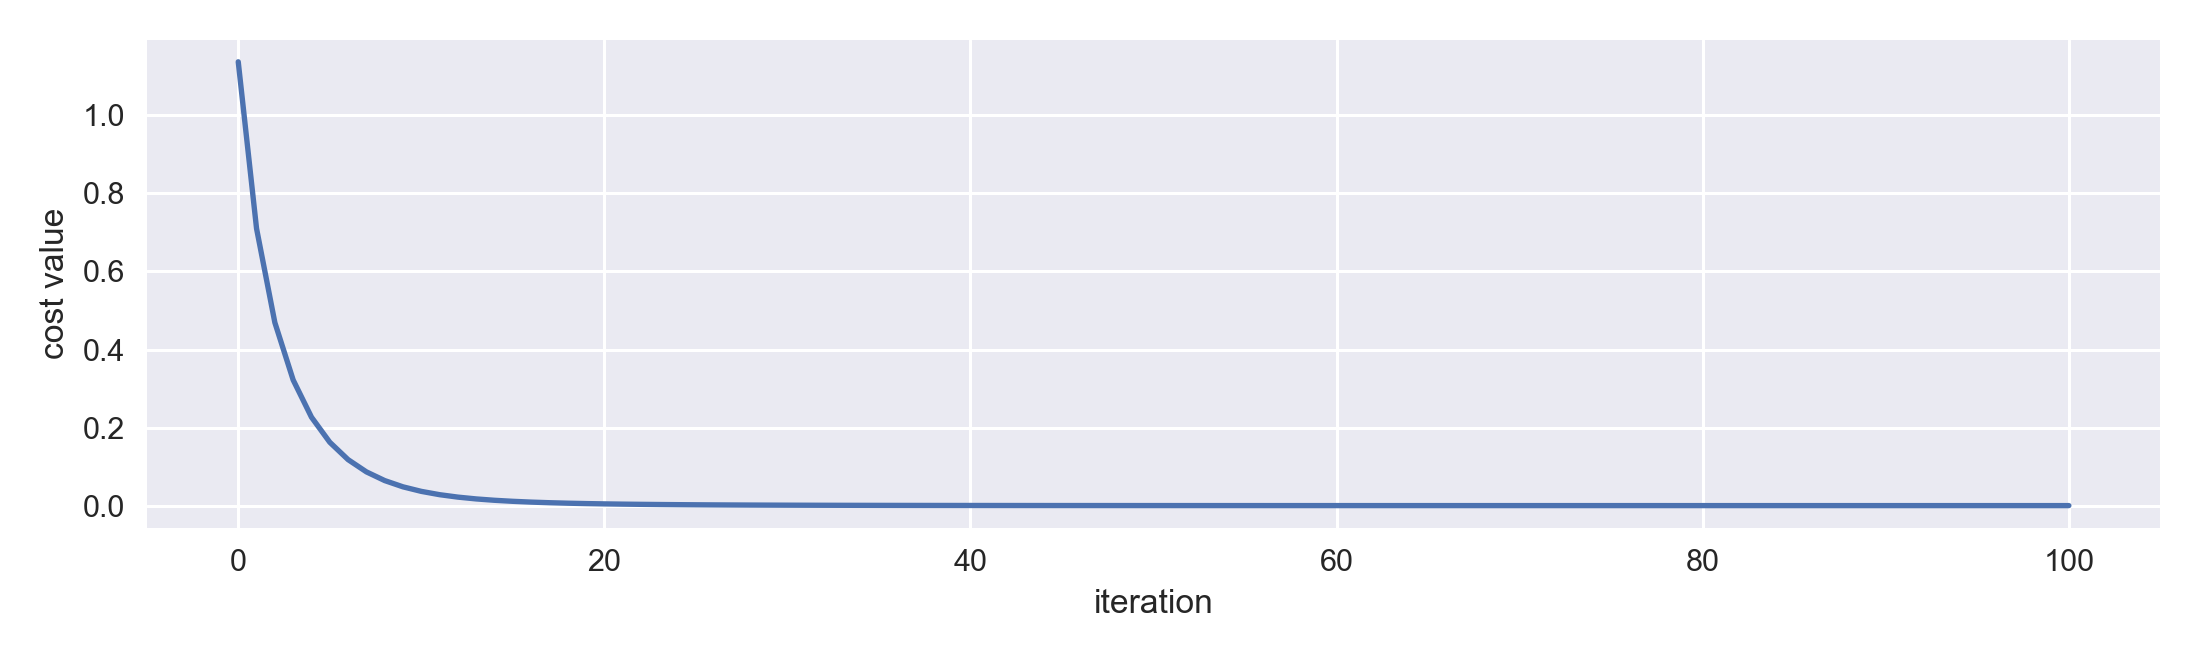

[[2.71954227e-04]
 [9.94322341e-01]
 [2.49743971e-04]
 [8.91329964e-03]]


In [418]:
# Entire pipeline using all data
dataset = read_all_files('datasets/')

dataset_t = np.transpose(dataset, (1,0))
hr = dataset_t[0]
cad = dataset_t[1]
pwr = dataset_t[2]
hr_next = dataset_t[3]

# least_squares using dataset input
def least_squares_set(w,hr,cad,pwr,hr_next):
    hr1 = model(w,hr,cad,pwr)
    cost = np.sum((hr1[0]-hr_next[0])**2)
    return cost/hr.size

hr_normalizer, hr_inverse_normalizer = standard_normalizer(hr[np.newaxis])
cad_normalizer, cad_inverse_normalizer = standard_normalizer(cad[np.newaxis])
pwr_normalizer, pwr_inverse_normalizer = standard_normalizer(pwr[np.newaxis])

hr_normalized = hr_normalizer(hr)
cad_normalized = cad_normalizer(cad)
pwr_normalized = pwr_normalizer(pwr)
hr_next_normalized = hr_normalizer(hr_next)

g = lambda w,hr=hr_normalized,cad=cad_normalized,pwr=pwr_normalized, hr_next=hr_next_normalized: least_squares_set(w,hr,cad,pwr,hr_next)
w_size = 4 # The number of weights
w_init = 0.1*np.random.randn(w_size,1)
max_its = 100
alpha = 10**(-1)
w_hist,train_hist = gradient_descent(g,w_init,alpha,max_its,verbose=False)

# print out that cost function history plot
plot_series(train_hist)

# Get best weights and trained model
ind = np.argmin(train_hist)
w_best = w_hist[ind]
g_best = train_hist[ind]
print(w_best)

all_data_model = lambda hr,cad,pwr,w=w_best: model(w,hr_normalizer(hr),cad_normalizer(cad),pwr_normalizer(pwr))

<IPython.core.display.Javascript object>


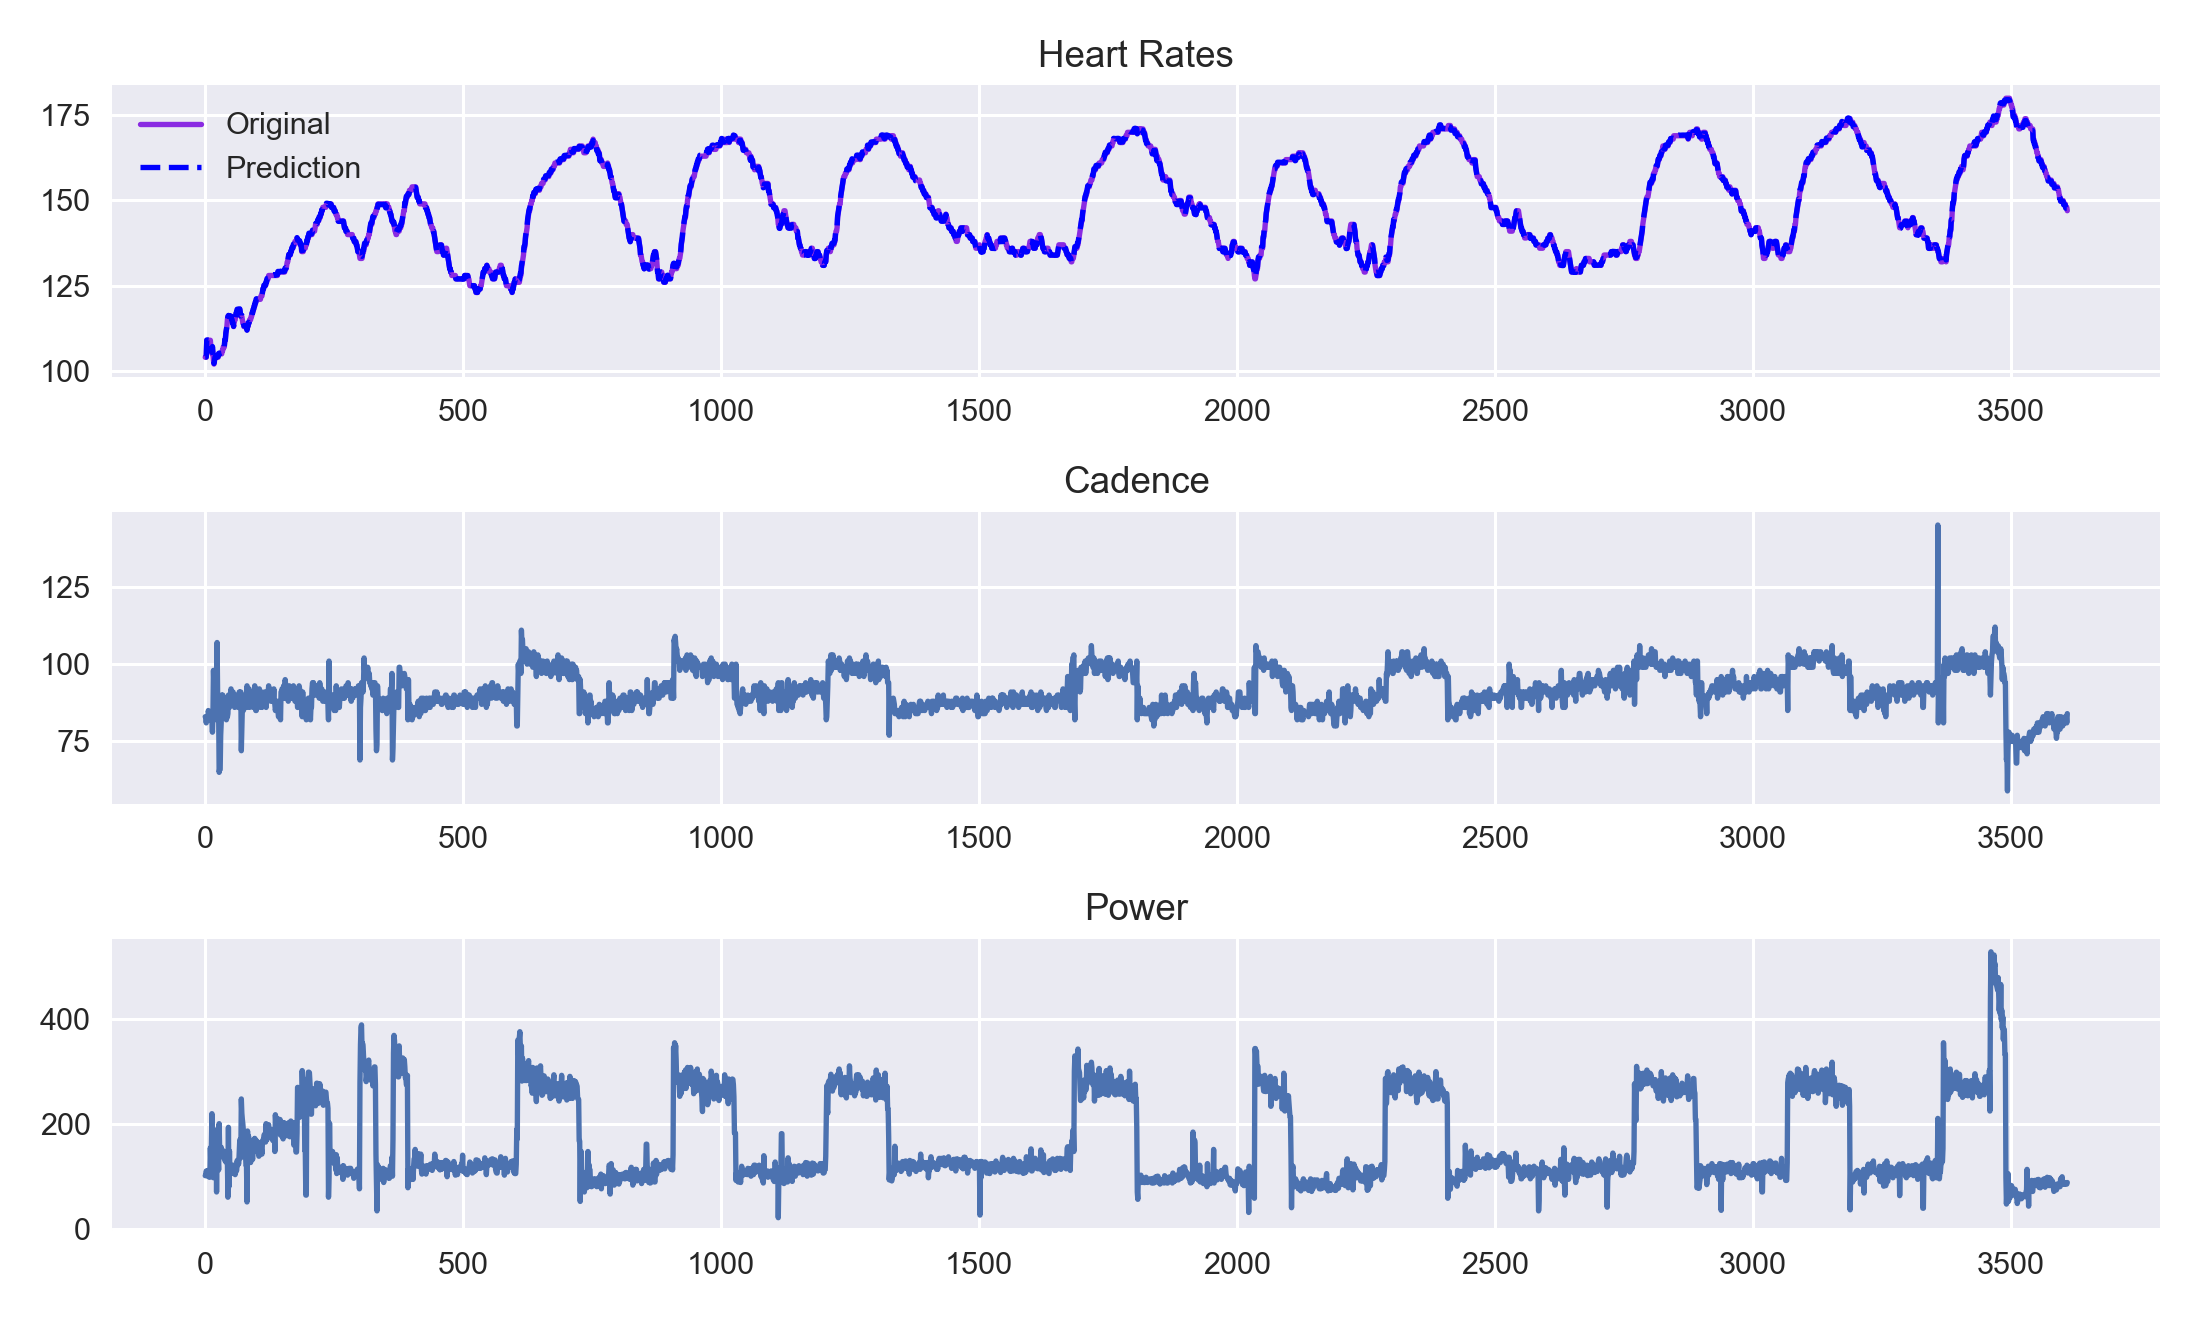

1299.0468311193022

In [135]:
# Plotting the actual with predicted values from the imitator together
predict, cost = plot_data_and_model(hr, cad, pwr, trained_model)
cost

<IPython.core.display.Javascript object>


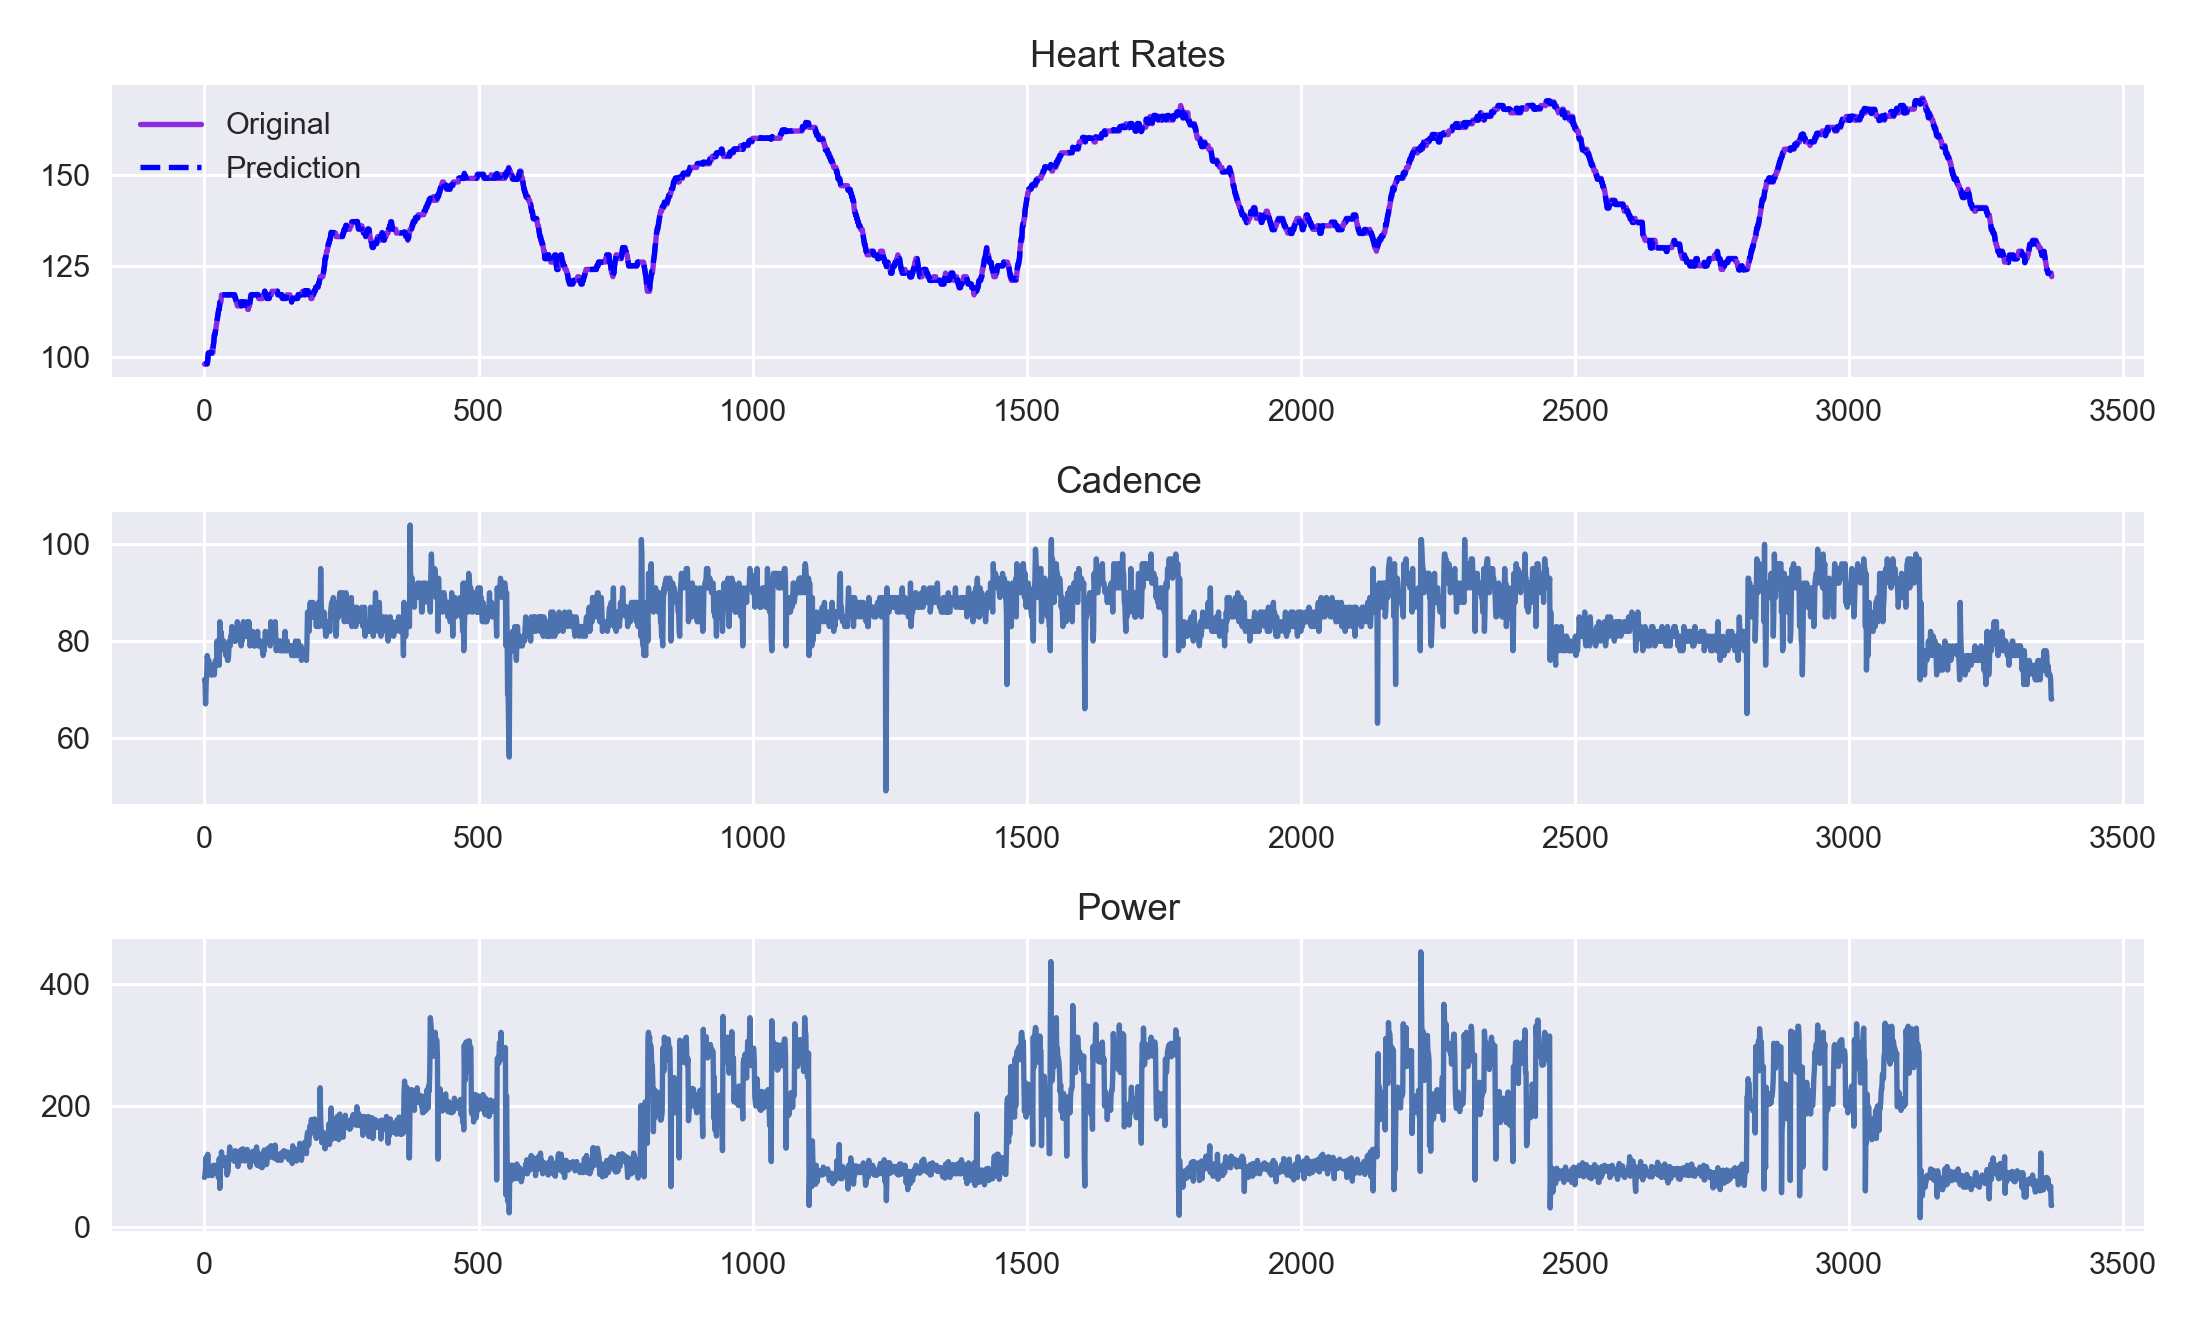

999.9681827341453

In [33]:
# Trying the same model with a new dataset
(test_hr, test_cad, test_pwr) = readin('datasets/2555883786.xml')
test_predict, test_cost = plot_data_and_model(test_hr, test_cad, test_pwr, trained_model)
test_cost

In [367]:
def test_predict(s_hr, cad, pwr, trained_model):
    hr = [s_hr]
    for i in range(len(cad)-1):
        next_hr = trained_model(hr[i], cad[i], pwr[i])[0]
        next_hr = hr_inverse_normalizer(next_hr)
#         print(next_hr)
        hr.append(next_hr)
    return np.asarray([hr])

def test_predict_steps(s_hr, cad, pwr, steps, trained_model):
    hr_in = [[s_hr] * steps]
    hr = [s_hr]
    for i in range(len(cad)-1):
        next_hr = trained_model(np.transpose(hr_in[i]), np.transpose(cad[i]), np.transpose(pwr[i]))[0][0]
        next_hr = hr_inverse_normalizer(next_hr)[0][0]
        hr.append(next_hr)
        hr_in.append(hr_in[i][1:] + [next_hr])
    return np.asarray([hr])

<IPython.core.display.Javascript object>


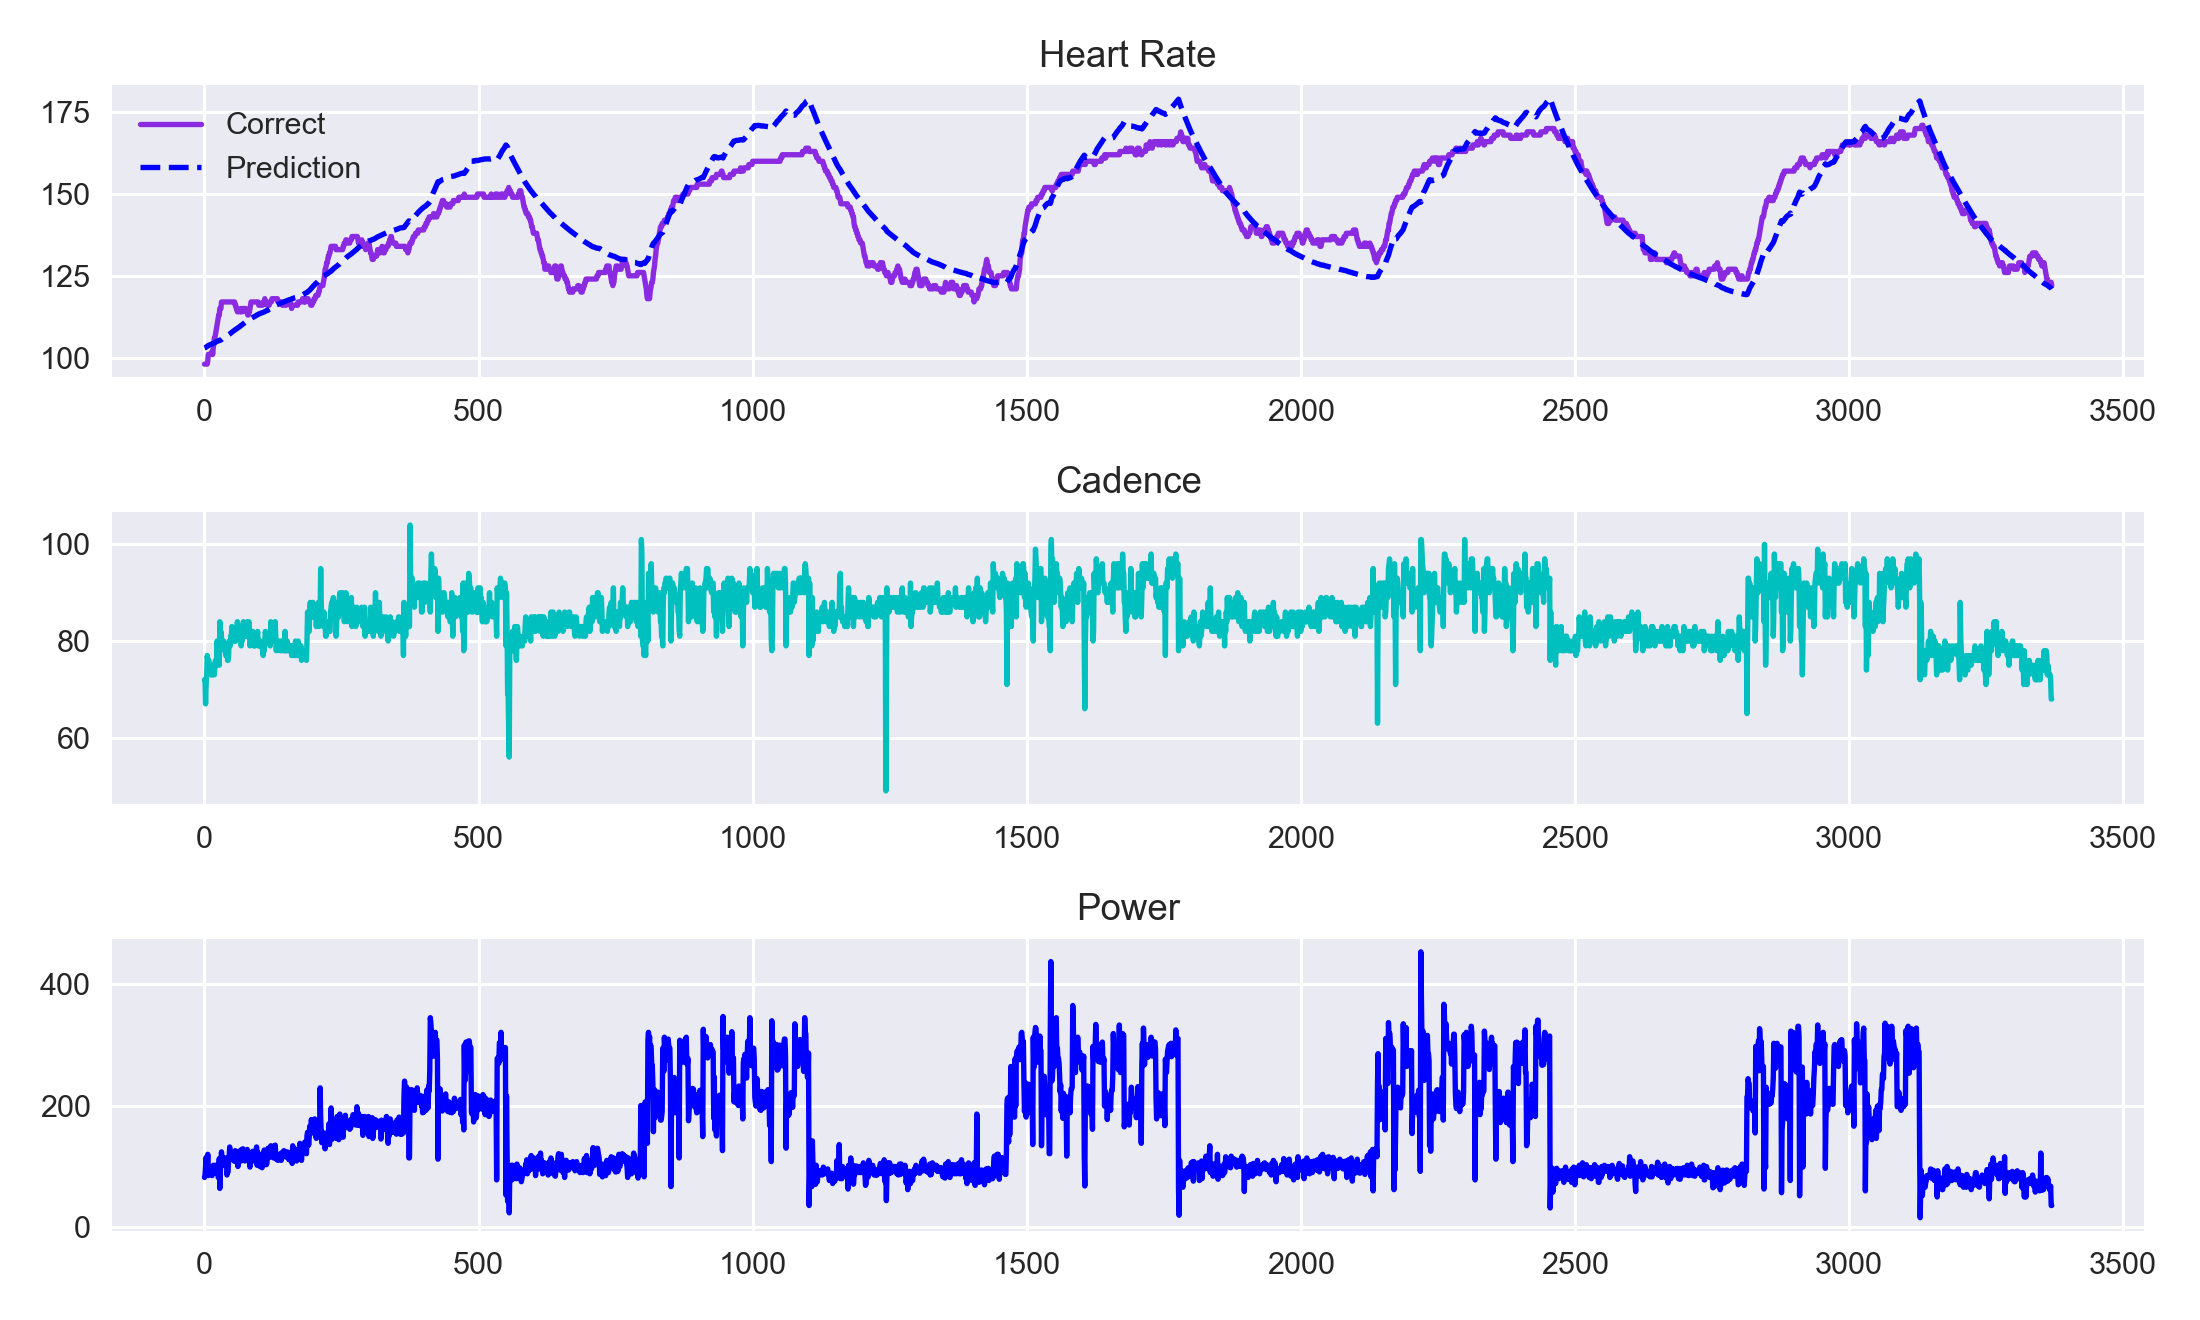

In [36]:
# Trying out sequential predict with real data
(test_hr, test_cad, test_pwr) = readin('datasets/2555883786.xml')
predict_hr = test_predict(103, test_cad, test_pwr, trained_model)
plot_data(predict_hr, test_pwr, test_cad, test_hr)

<IPython.core.display.Javascript object>


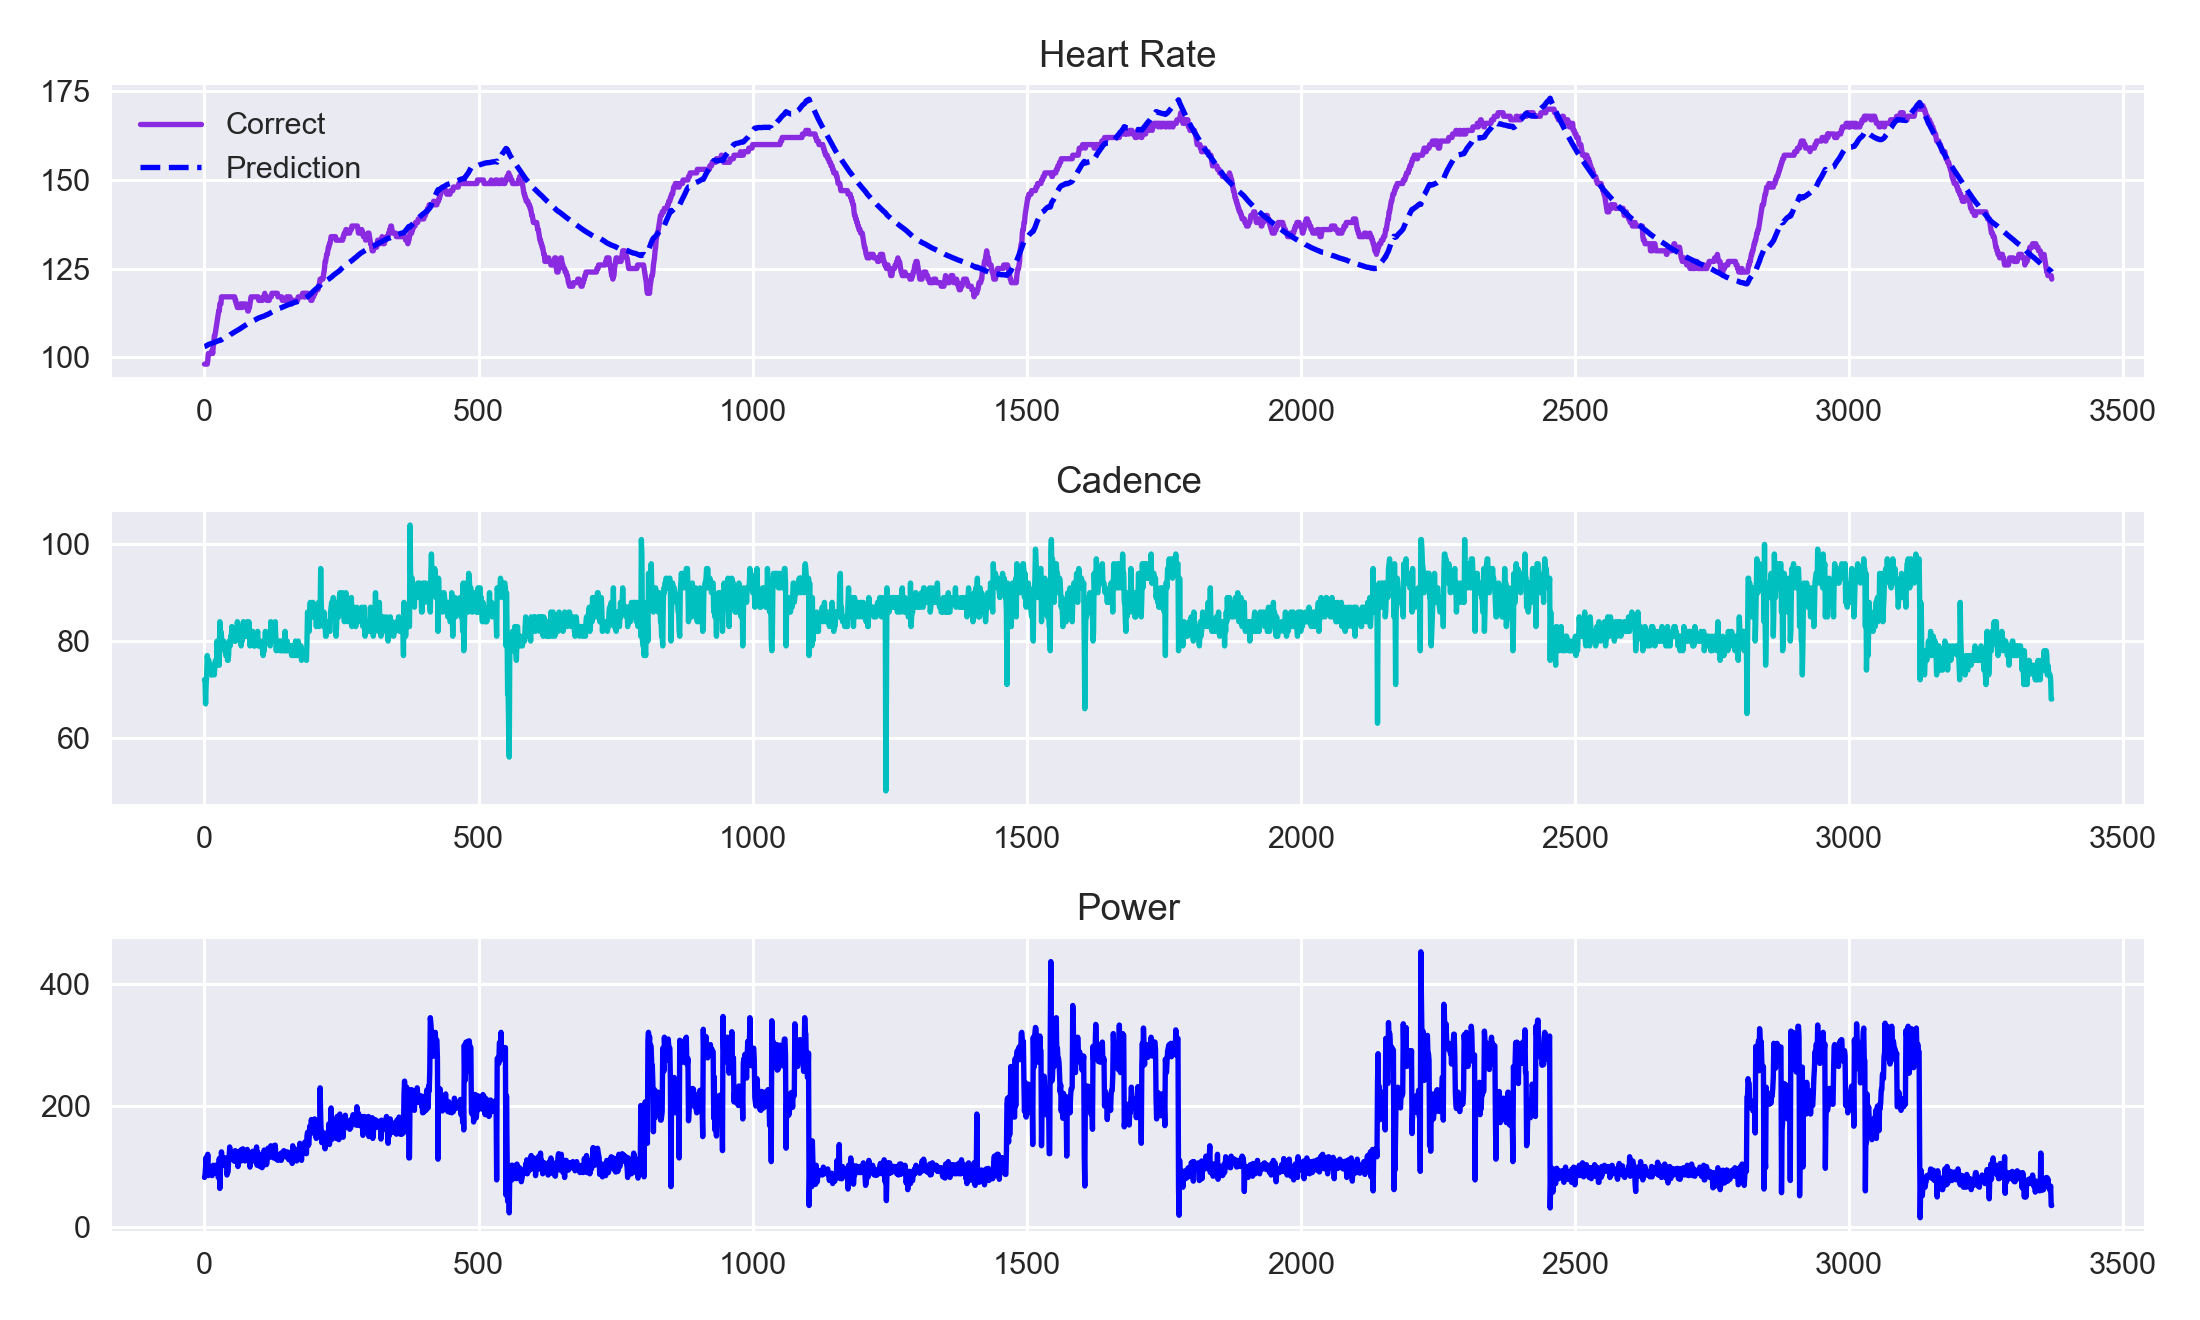

In [420]:
# Trained on all data
(test_hr, test_cad, test_pwr) = readin('datasets/2555883786.xml')
predict_hr = test_predict(103, test_cad, test_pwr, all_data_model)
plot_data(predict_hr[0], test_pwr, test_cad, test_hr)

<IPython.core.display.Javascript object>


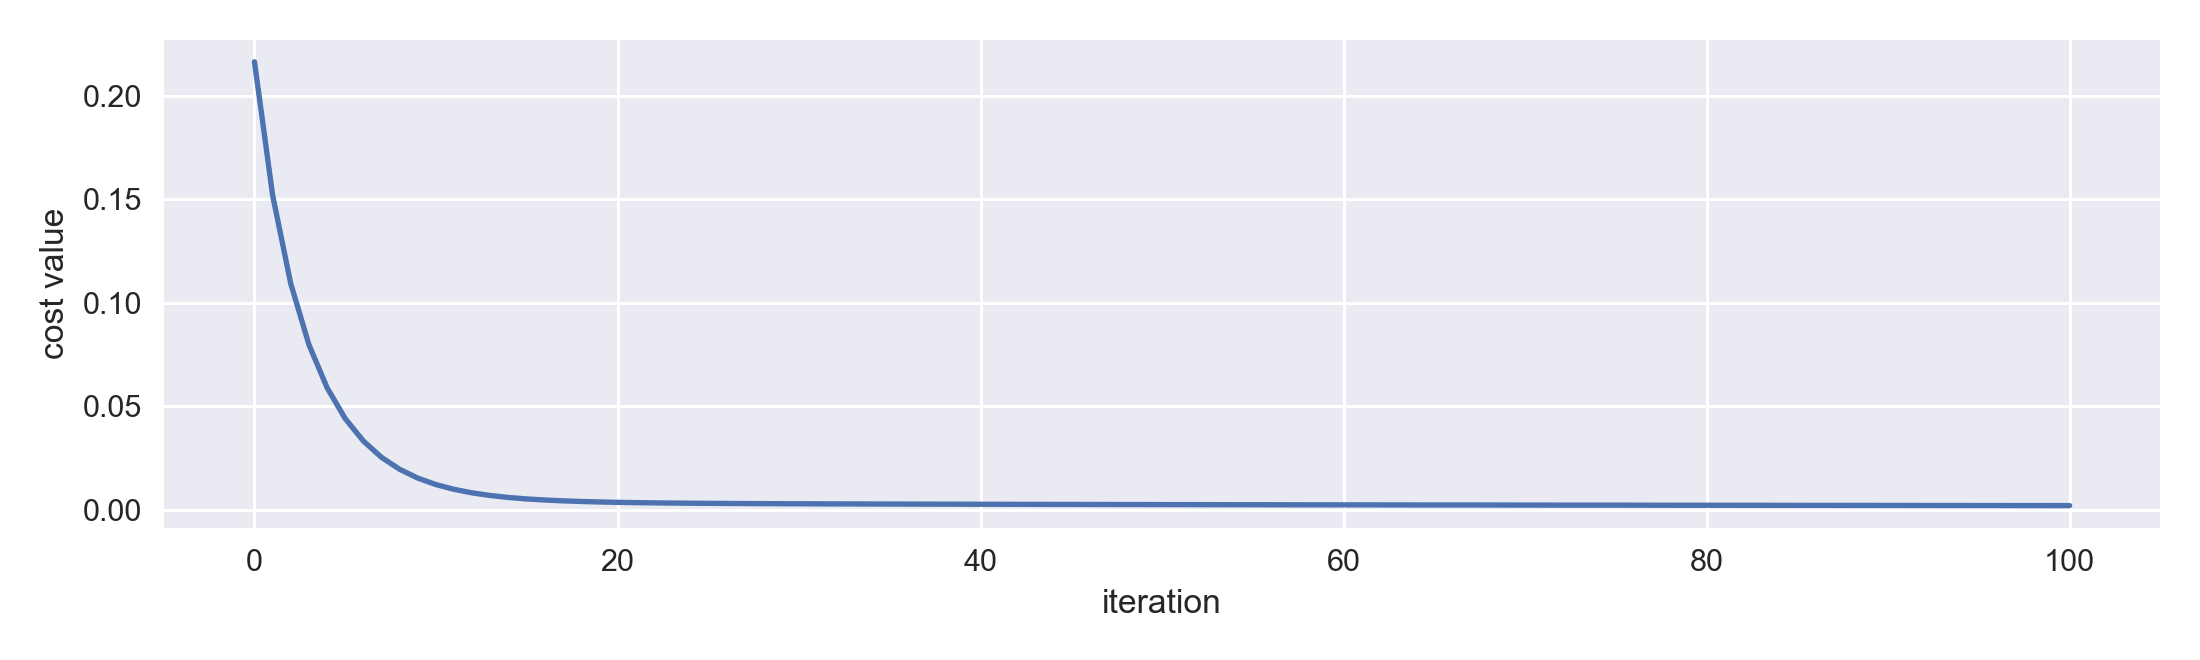

[[-0.00632417]
 [ 0.17031205]
 [ 0.12186308]
 [ 0.21922715]
 [ 0.1121549 ]
 [ 0.02436923]
 [ 0.01115572]
 [-0.00988044]
 [ 0.09951591]
 [-0.08174974]
 [ 0.29390519]
 [ 0.00082398]
 [-0.10759969]
 [ 0.0678245 ]
 [ 0.01814605]
 [ 0.05507103]
 [-0.06502443]
 [ 0.11723022]
 [ 0.00110114]
 [-0.01917314]
 [-0.07114637]
 [ 0.00712177]
 [-0.0123424 ]
 [ 0.14205553]
 [-0.00883552]
 [-0.07046893]
 [-0.17974965]
 [ 0.10645492]
 [ 0.00313768]
 [-0.02775016]
 [ 0.11176537]]


In [390]:
# Pipeline using a lookback of 10 timesteps

steps = 10

## if using all files in dataset
dataset = read_all_files_back('datasets/', 10)
hr = np.transpose(dataset[0])[0] # gets a list of all of the heart rates in one list
cad = np.transpose(dataset[1])[0]
pwr = np.transpose(dataset[2])[0]

## if using only one file
# (hr, cad, pwr) = readin('Mills.xml')
# dataset = seq_dataset(hr, cad, pwr, 10)


hr_normalizer, hr_inverse_normalizer = standard_normalizer(hr[np.newaxis])
cad_normalizer, cad_inverse_normalizer = standard_normalizer(cad[np.newaxis])
pwr_normalizer, pwr_inverse_normalizer = standard_normalizer(pwr[np.newaxis])

hr_normalized = hr_normalizer(dataset[0])
cad_normalized = cad_normalizer(dataset[1])
pwr_normalized = pwr_normalizer(dataset[2])
hr_next_normalized = hr_normalizer(dataset[3])

g = lambda w,hr=hr_normalized,cad=cad_normalized,pwr=pwr_normalized, hr_next=hr_next_normalized, steps = steps: back_least_squares(w,hr,cad,pwr,hr_next, steps)
w_size = steps*3 + 1 # The number of weights
w_init = 0.1*np.random.randn(w_size,1)
max_its = 100
alpha = 10**(-1)
w_hist,train_hist = gradient_descent(g,w_init,alpha,max_its,verbose=False)

# print out that cost function history plot
plot_series(train_hist)

# Get best weights and trained model
ind = np.argmin(train_hist)
w_best = w_hist[ind]
g_best = train_hist[ind]
print(w_best)

lookback_model = lambda hr,cad,pwr,steps = steps, w=w_best: back_model(w,hr_normalizer(hr),cad_normalizer(cad),pwr_normalizer(pwr), steps)

<IPython.core.display.Javascript object>


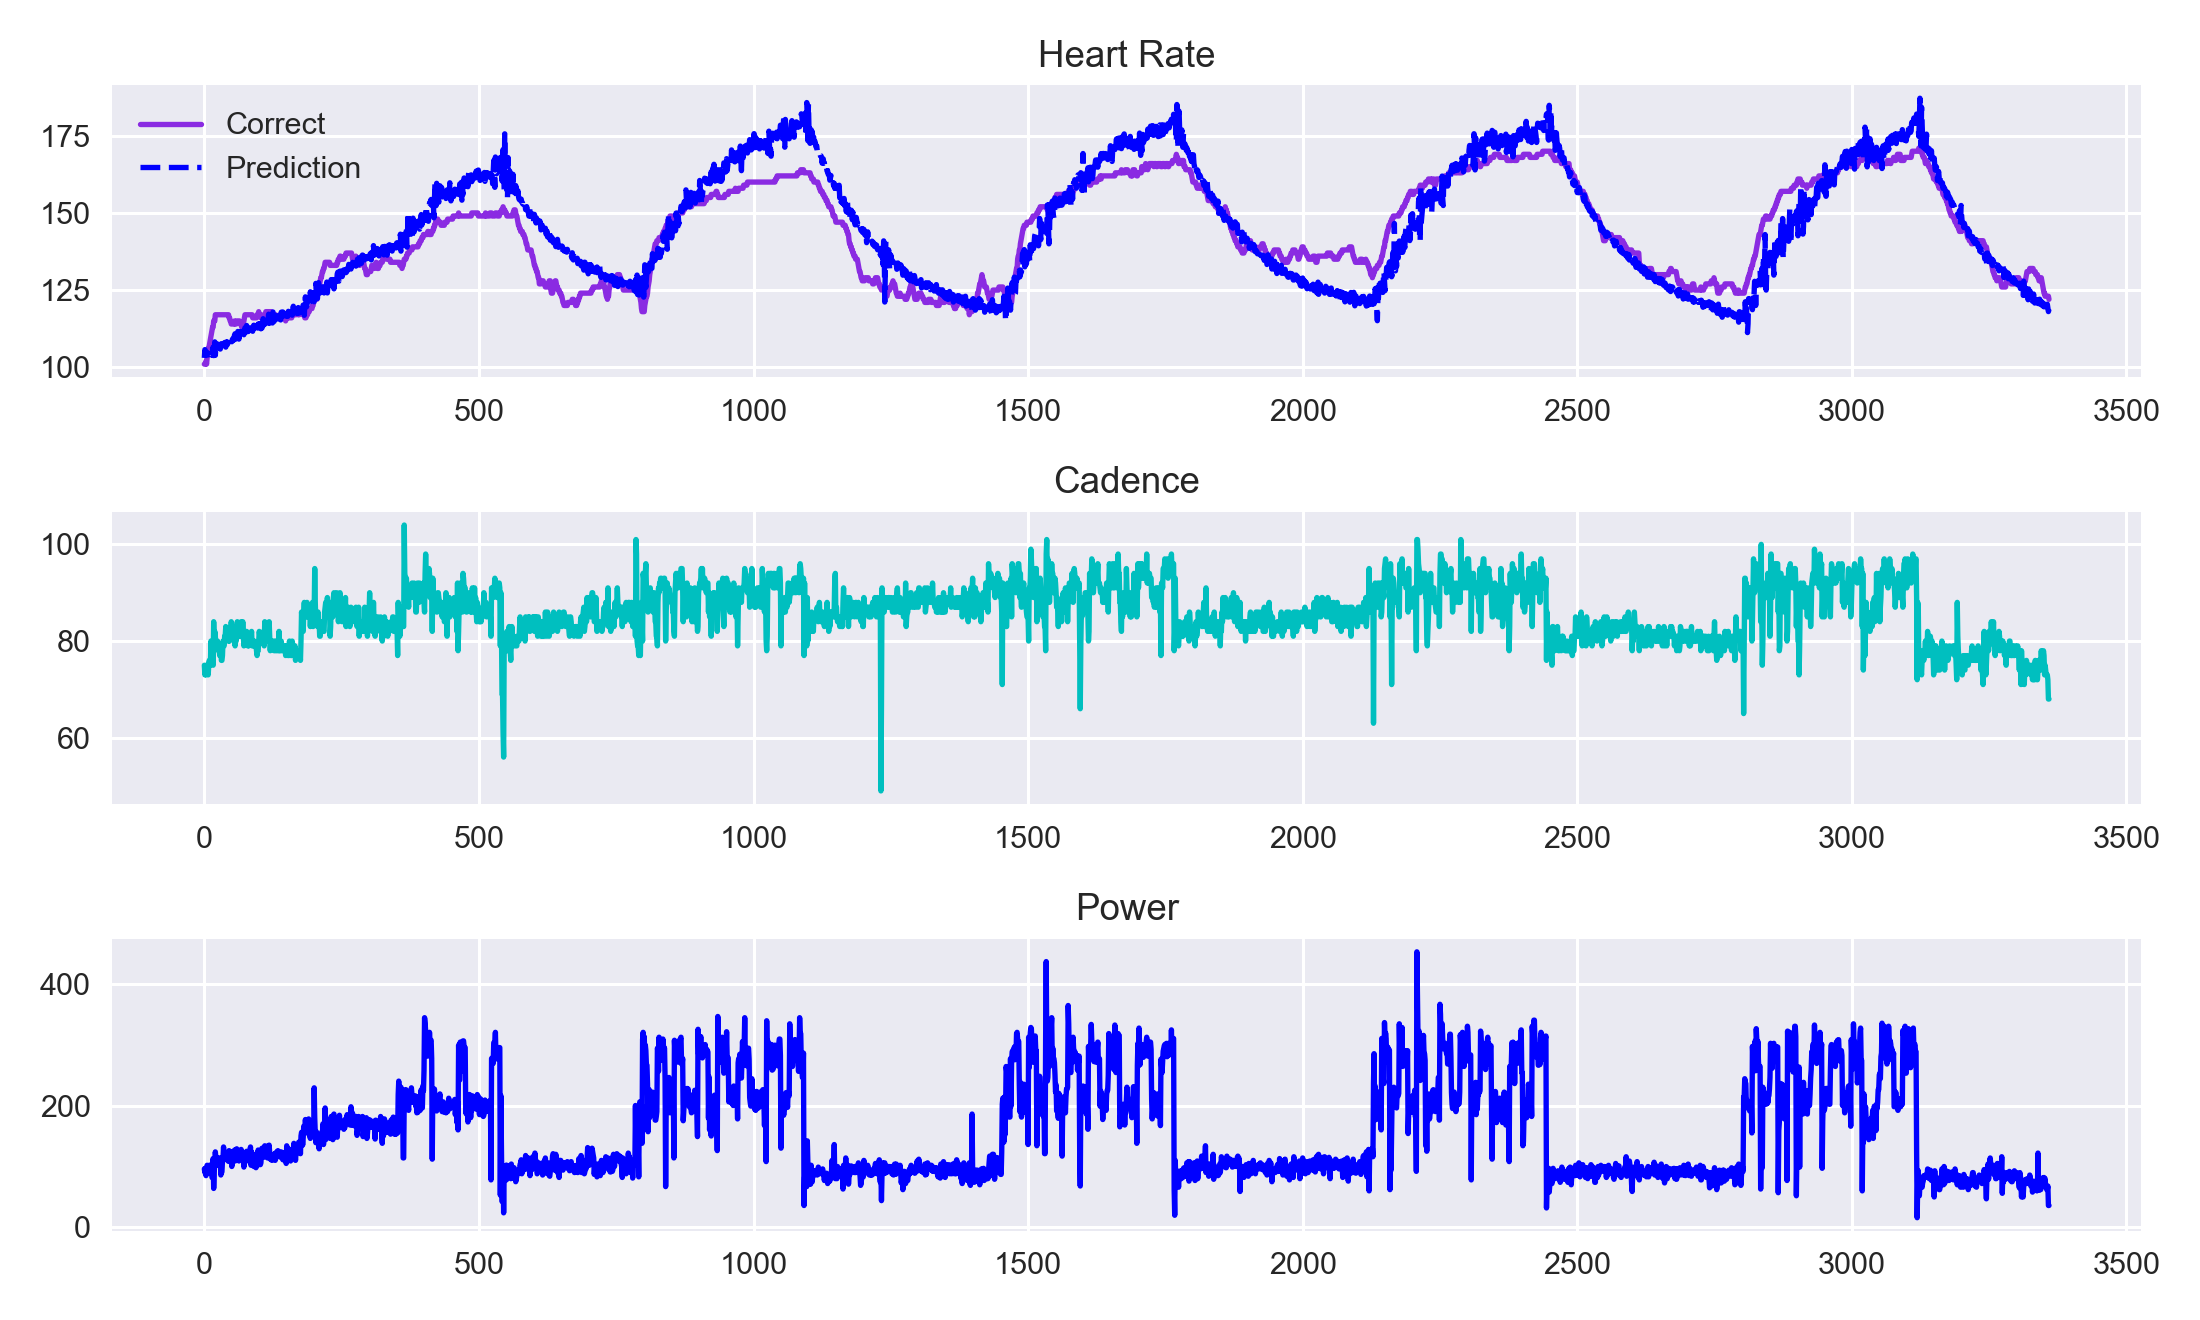

In [370]:
# Trying out with lookback of 10 timesteps (lookback_model) trained only on one file
(test_hr, test_cad, test_pwr) = readin('datasets/2555883786.xml')
test_dataset = seq_dataset(test_hr, test_cad, test_pwr, 10)
predict_hr = test_predict_steps(103, test_dataset[1], test_dataset[2], 10, lookback_model)
plot_data(predict_hr[0], test_pwr[11:], test_cad[11:], test_hr[11:])

<IPython.core.display.Javascript object>


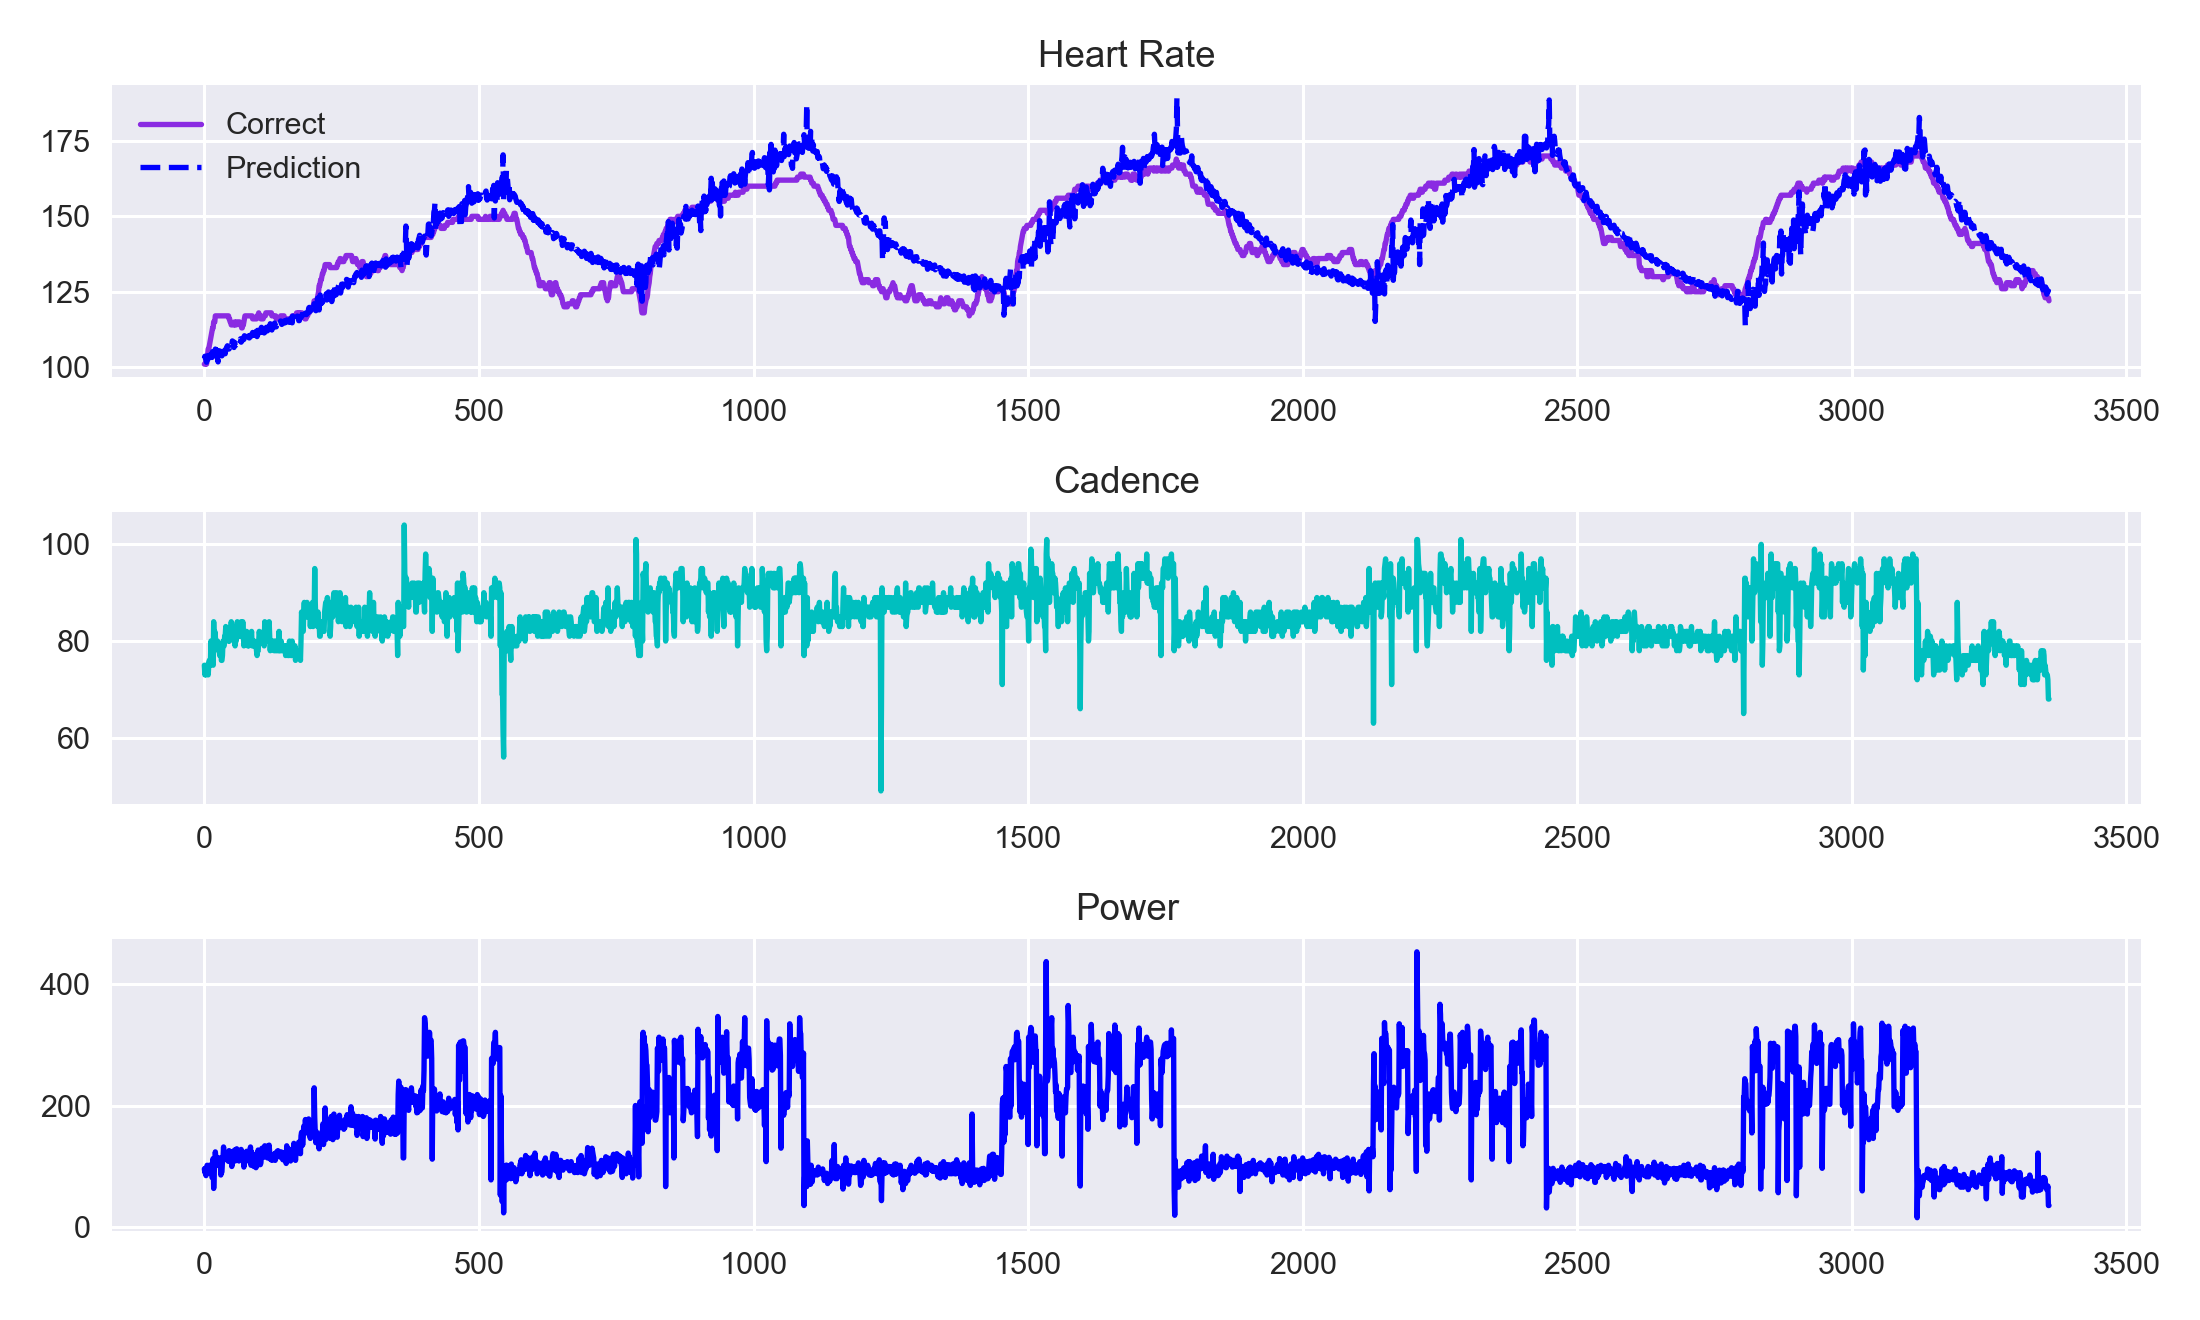

In [389]:
# Trying out with lookback of 10 timesteps (lookback_model) trained on all data
(test_hr, test_cad, test_pwr) = readin('datasets/2555883786.xml')
test_dataset = seq_dataset(test_hr, test_cad, test_pwr, 10)
predict_hr = test_predict_steps(103, test_dataset[1], test_dataset[2], 10, lookback_model)
plot_data(predict_hr[0], test_pwr[11:], test_cad[11:], test_hr[11:])

## Controller

With the tuned imitator, it will be used to determine the power output required to follow a heart-rate target sequence. For cycling, Eric's heart-rate zones are as follows (based off of max HR of 192 bpm):
* **Zone 1:** 0-113 bpm
* **Zone 2:** 113-149 bpm
* **Zone 3:** 149-168 bpm
* **Zone 4:** 168-186 bpm
* **Zone 5:** >186 bpm

For simplicity, we will assume that cadence is consistently 95 throughout, so the only variable the controller is tuning is the power.

<IPython.core.display.Javascript object>


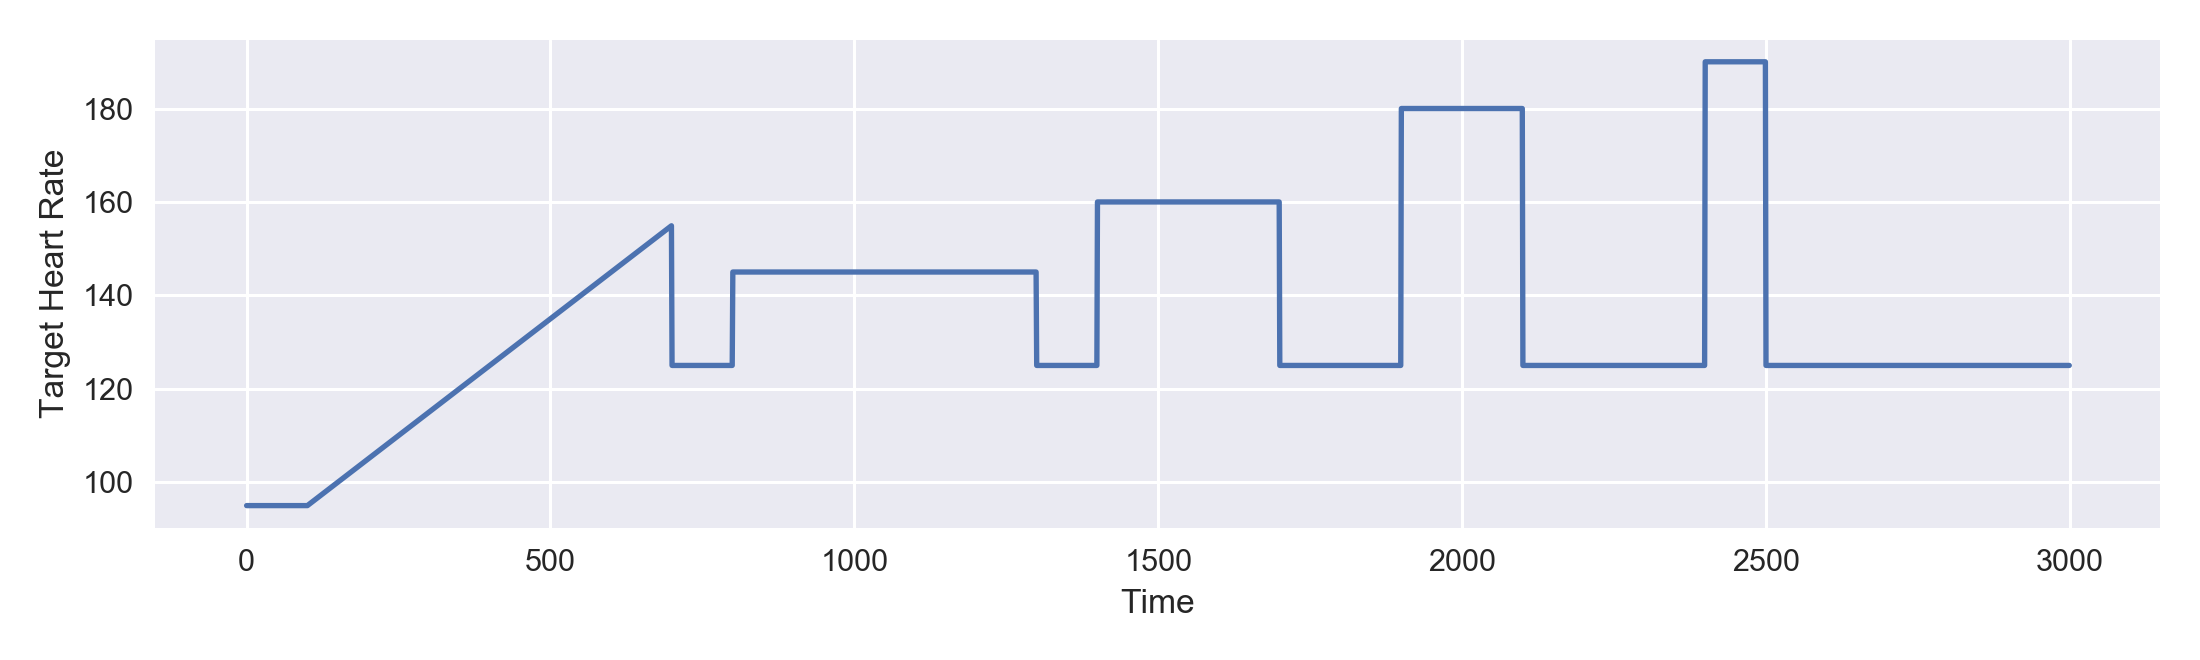

In [450]:
target = [95] * 100
target = target + list(np.arange(95, 155, 0.1)) # warmup
target = target + [125] * 100 # rest
target = target + [145] * 500 # Zone 2
target = target + [125] * 100 # rest
target = target + [160] * 300 # Zone 3
target = target + [125] * 200 # rest
target = target + [180] * 200 # Zone 4
target = target + [125] * 300 # rest
target = target + [190] * 100 # Zone 5
target = target + [125] * 500 # cooldown
target = np.array(target)
cad = [95] * 3000
plot_series(target, 'Target Heart Rate', 'Time')

In [495]:
# zero order coordinate search
def coordinate_descent(g,w_init,alpha,max_its, max_pwr,verbose): 
    # flatten the input function
    g_flat, unflatten, w = flatten_func(g, w_init)

    # record history
    w_hist = [unflatten(w)]
    cost_eval = g_flat(w)
    train_hist = [cost_eval]

    # start loop
    N = np.size(w)
    for k in range(1,max_its+1):              
        # random shuffle of coordinates
        c = np.random.permutation(N)

        # forming the direction matrix out of the loop
        train_cost = train_hist[-1]

        # loop over each coordinate direction
        for n in range(N):
            direction = np.zeros((N,1)).flatten()
            direction[c[n]] = 1

            # evaluate all candidates
            evals =  [g_flat(w + alpha*direction)]
            evals.append(g_flat(w - alpha*direction))
            evals = np.array(evals)

            # if we find a real descent direction take the step in its direction
            ind = np.argmin(evals)
            if evals[ind] < train_cost:
                # take step
                w = w + ((-1)**(ind))*alpha*direction
                train_cost = evals[ind]

        # record weight update, train and val costs
        w_hist.append(unflatten(w))
        train_hist.append(train_cost)

        # print update
        if verbose == True:
            print ('step ' + str(k+1) + ' complete, train cost = ' + str(np.round(train_hist[-1],4)[0]))

    # print update and return
    if verbose == True:
        print ('finished all ' + str(max_its) + ' steps')
    return w_hist,train_hist
def PID_controller(e_t,h_t,d_t,w):    
    # note here in terms of inputs
    # e_t = current error
    # h_t = integral of error
    # d_t = derivative of error
    return w[0] + w[1]*e_t + w[2]*h_t + w[3]*d_t
# loop for evaluating control model over all input/output action/state pairs
# Our inputs here:
# s_1 - the initial condition state
# x - sequence of training set points
# w - the control model parameters
def control_loop(x,w, trained_model, max_pwr):
    # initialize key variables and containers
    hr_t = copy.deepcopy(hr_1)
    h_t = 0
    d_t = 0
    frac = 1/float(np.size(x))
    pwr_history = []
    hr_history = [hr_t]
    error_history = []
    
    # loop over training set points and run through controller, then 
    # system models
    for t in range(np.size(x) - 1):
        # get current set point
        x_t = x[t]

        # update error
        e_t = x_t - hr_t
        error_history.append(e_t)
        
        # update integral of error
        h_t = h_t + frac*e_t
        
        # update derivative of error 
        if t > 0:
            d_t = frac*(error_history[-1] - error_history[-2])
            
        # send error, integral, and derivative to PID controller
        pwr_t = PID_controller(e_t,h_t,d_t,w)
        
        # clip power to match my power abilities
        if pwr_t > max_pwr:
            pwr_t = max_pwr
        elif pwr_t < 0:
            pwr_t = 0
        
        # send action to system model
        # Assuming cadence is maintained at 95
        hr_t = trained_model(hr_t, 95, pwr_t)
        hr_t = hr_inverse_normalizer(hr_t)[0][0]
        
        # store state output, and actions (for plotting)
        hr_history.append(hr_t)
        pwr_history.append(pwr_t)

    # transition to arrays
    hr_history = np.array(hr_history)[np.newaxis,:]
    pwr_history = np.array(pwr_history)[np.newaxis,:]
    
    # return velocities and control history
    return hr_history,pwr_history

# an implementation of the least squares cost for PID controller tuning
# note here: s is an (1 x T) array and a an (1 x T-1) array
def least_squares_PID(w,x, trained_model, max_pwr):
    # system_loop - runs over all action-state pairs and produces entire
    # state prediction set
    hr_history,pwr_history = control_loop(x,w, trained_model, max_pwr)

    # compute least squares error between real and predicted states
    cost = np.sum((hr_history[0][1:] - x[1:])**2)
    return cost/float(x.shape[0]-1)

In [499]:
# Using linear model that only looks at the previous timestep, trained on all data
cur_model = all_data_model
max_pwr = 800

g = lambda w, x=target, trained_model=cur_model, max_pwr=max_pwr: least_squares_PID(w,x, trained_model, max_pwr)

hr_1 = 70
w_init = 0.1*np.random.randn(4,1)
max_its = 50
alpha = 1

w_hist,train_hist = coordinate_descent(g,w_init,alpha,max_its,max_pwr,verbose=False)
ind = np.argmin(train_hist)

# corresponding weights and cost evaluation
w_best = w_hist[ind]
g_best = train_hist[ind]
print('======== best set of weights ========')
print(w_best)
print('======== best associated cost val ========')
print(g_best)

======== best set of weights ========
[[ 50.04459594]
 [ 33.11517296]
 [  1.96187246]
 [-24.00569746]]
======== best associated cost val ========
[137.86231781]


<IPython.core.display.Javascript object>


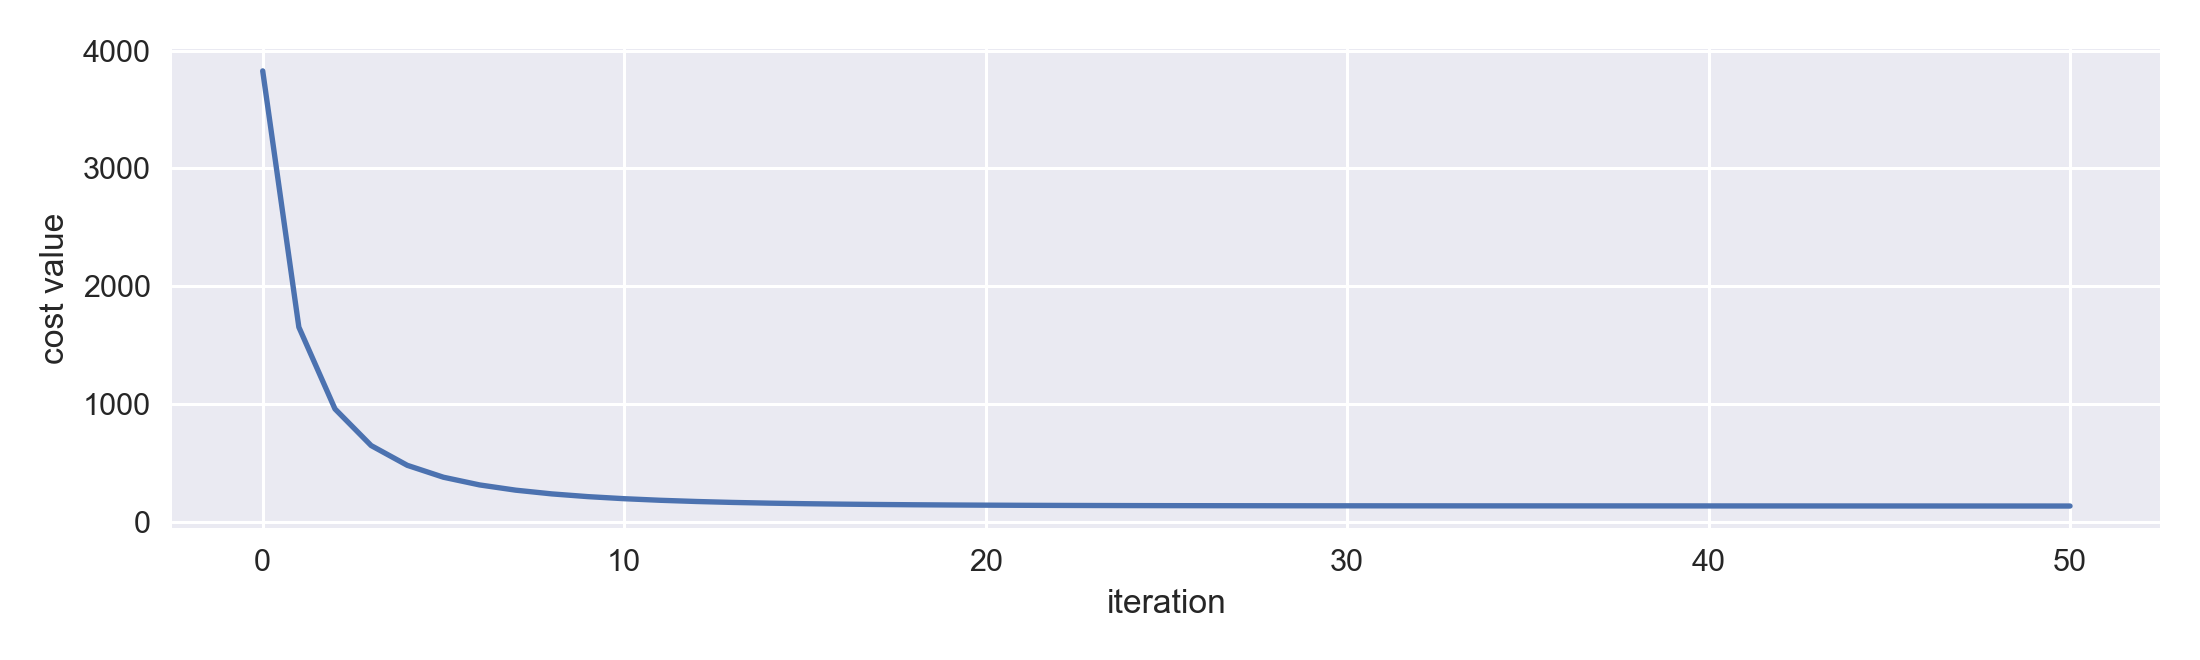

In [500]:
plot_series(train_hist)

<IPython.core.display.Javascript object>


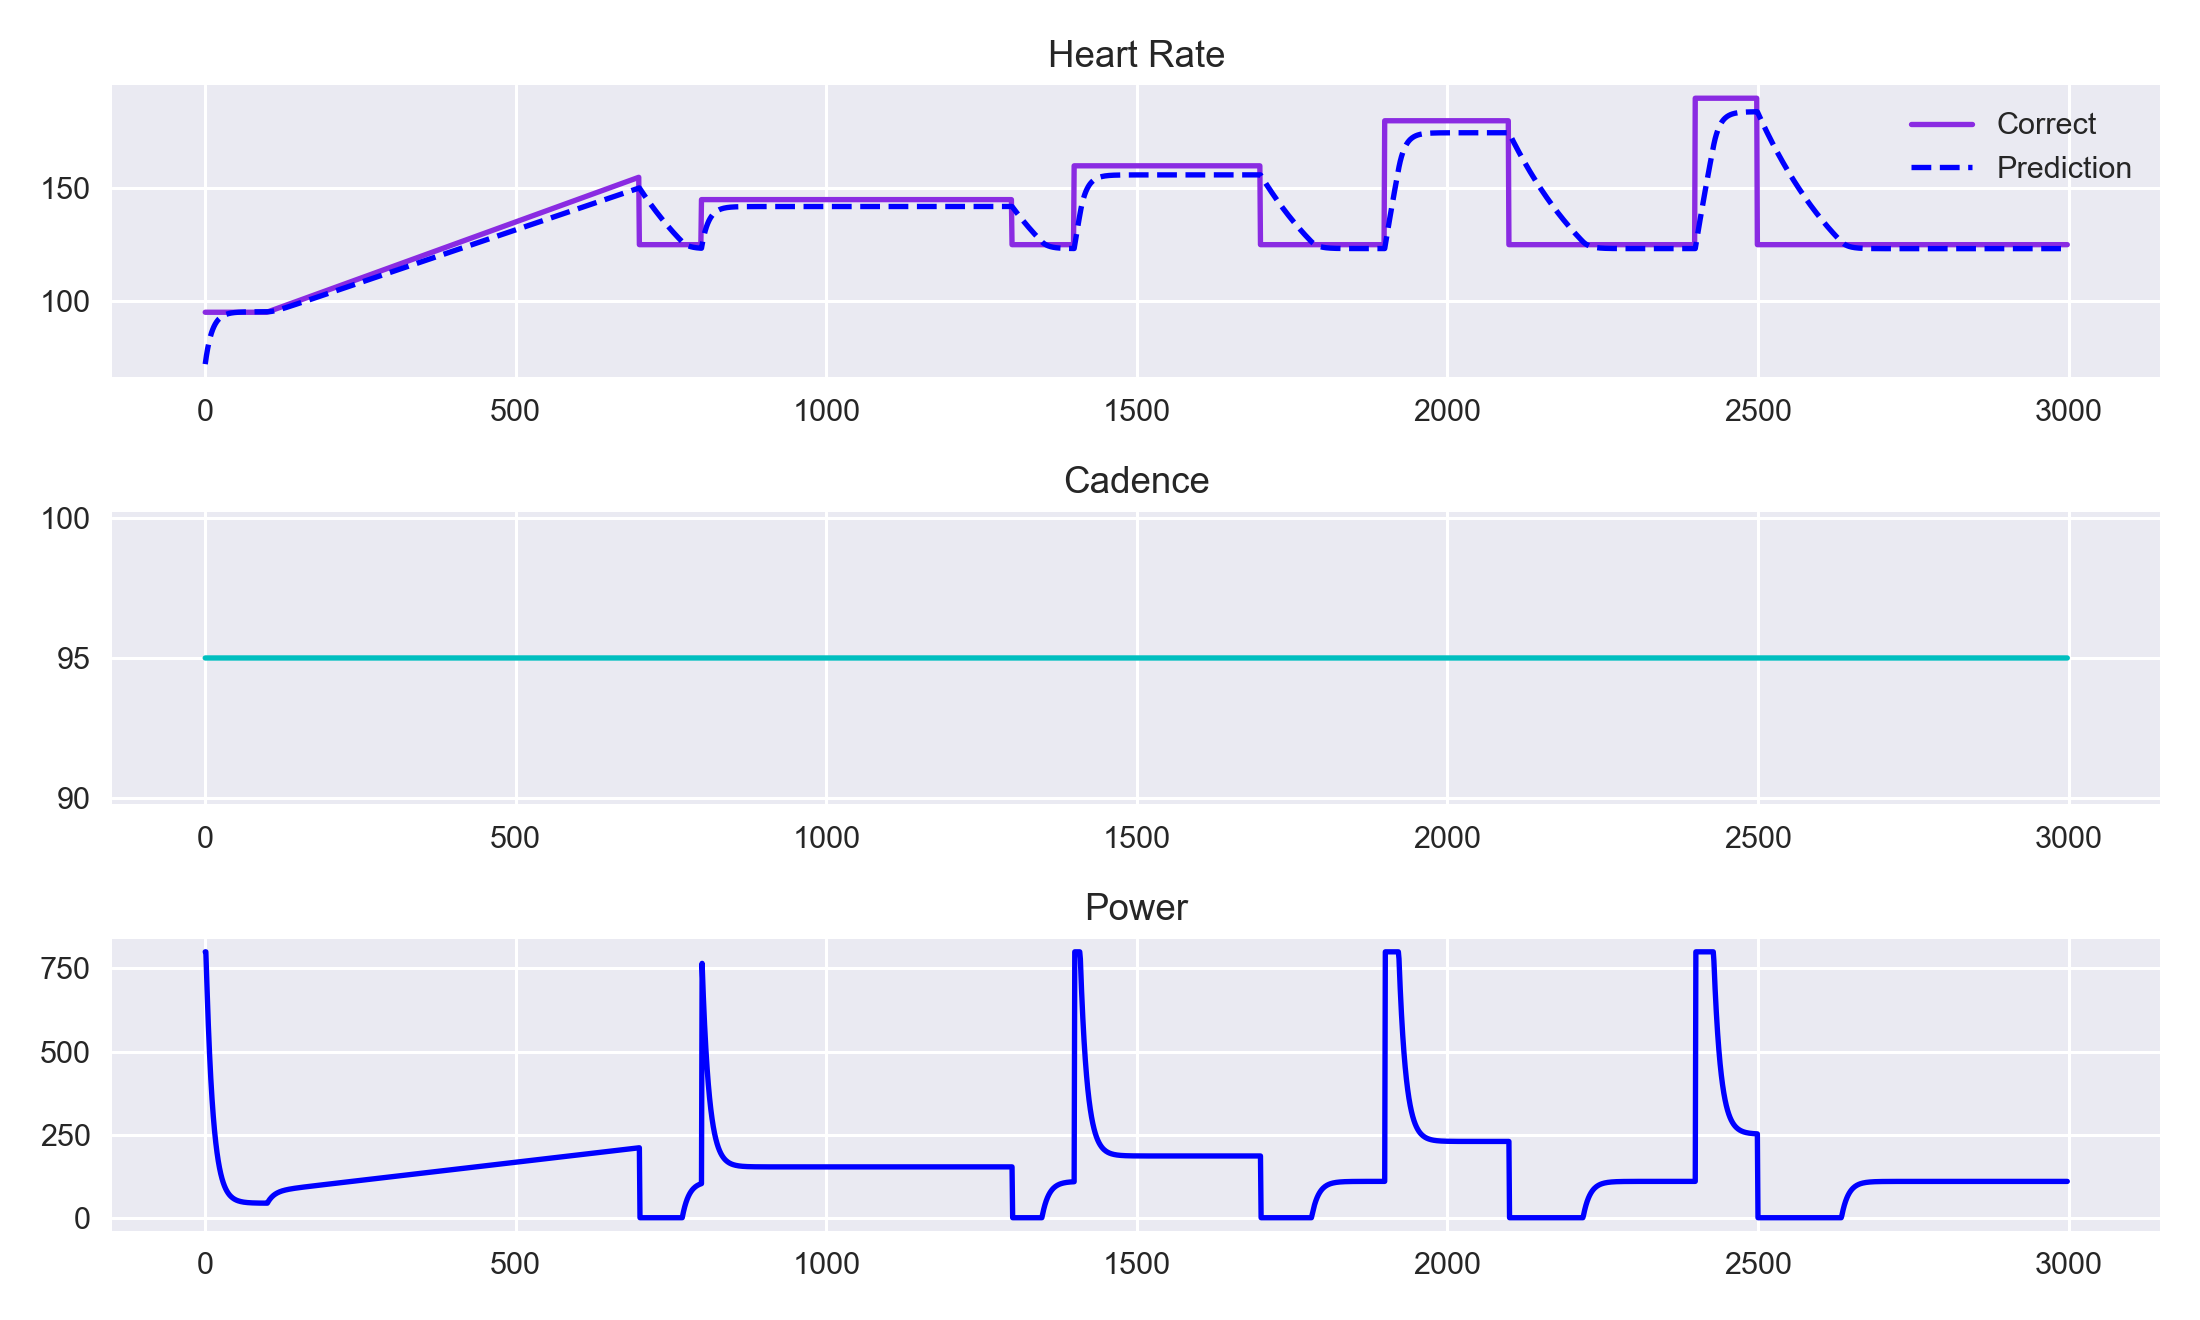

In [501]:
pid_hr, pid_pwr = control_loop(target, w_best, cur_model, max_pwr)
plot_data(np.transpose(pid_hr)[1:], np.transpose(pid_pwr), np.array(cad[1:]), target[1:])